<h1>The Geometry of Exotic Options: Visual Intuition and Numerical Methods</h1>



The article links

Medium: 

LinkedIn: 

<h3>1. A clear classification of exotic options, organised by the structural feature that shapes their behaviour</h3>

____
Graphs or animations
____

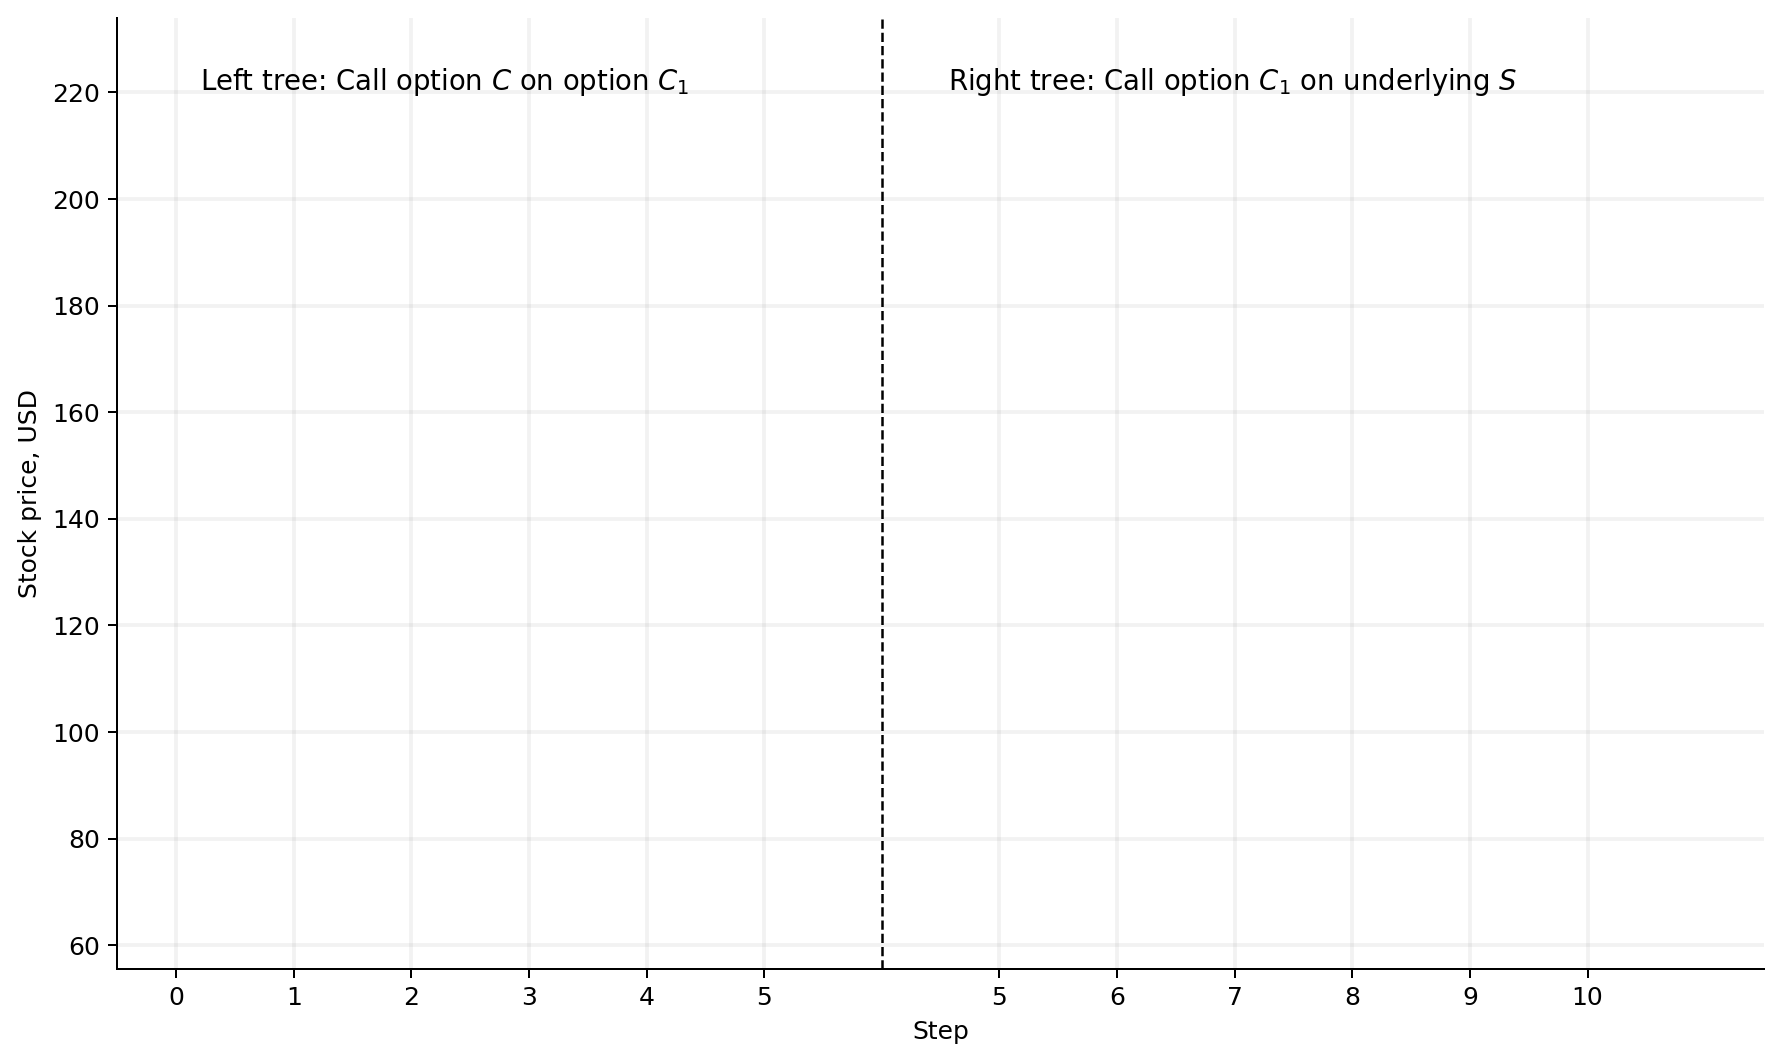

/var/folders/jg/qxxd4l517rj259v_s_gwlg980000gn/T/ipykernel_73168/3273155596.py:656: UserWarning: frames=<generator object frame_sequence at 0x10e4cd220> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(


In [ ]:
# I want to rebuild it to make the structure more standard and readable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

colors = ["#c1c7efff", "#6376efff", "#112291ff"]

# --- Parameters ---
S0 = 120.0
K  = 100.0
r  = 0.05
sigma = 0.20
T  = 1.0
N  = 10  # one "layer" corresponds to two future nodes and one current node (array length is N+1)
option_type = "call"       # "call" or "put" for the underlying option
option_type_main = "call"  # "call" or "put" for the option on the option
K_main = 2
is_american = False        # True for American, False for European (both trees)

# Changes
max_number_of_layers = 5   # this will be the interface time T1 between the two blocks

# --- CRR (Cox–Ross–Rubinstein) parameters ---
dt = T / N
u  = np.exp(sigma * np.sqrt(dt))
d  = 1.0 / u
disc = np.exp(-r * dt)
p = (np.exp(r * dt) - d) / (u - d)

# --- Stock price tree ---
# tree_S is not one big rectangular NumPy array.
# It is a Python list, and each element of that list is a NumPy array of a different length.
tree_S = [
    np.array([S0 * (u**j) * (d**(i - j)) for j in range(i + 1)], dtype=float)
    for i in range(N + 1)
]

def payoff_fn(S):
    """Payoff of the underlying option C1(S, T)."""
    if option_type == "call":
        return np.maximum(S - K, 0.0)
    else:
        return np.maximum(K - S, 0.0)

# --- Option values for the right block (underlying option C1) ---
# We only build the subtree starting at level max_number_of_layers (T1) up to maturity.
tree_Vr = [np.zeros_like(level) for level in tree_S[max_number_of_layers:]]

# Final payoff at maturity for the underlying option
tree_Vr[-1] = payoff_fn(tree_S[-1])  # important: only the last stock layer matters for payoff

# Backward induction inside the right block (from T to T1)
for i in range(max_number_of_layers - 1, -1, -1):
    continuation = disc * (p * tree_Vr[i + 1][1:] + (1.0 - p) * tree_Vr[i + 1][:-1])
    if is_american:
        # American-style exercise inside the right block
        exercise = payoff_fn(tree_S[i + max_number_of_layers])
        tree_Vr[i] = np.maximum(continuation, exercise)
    else:
        tree_Vr[i] = continuation

# --- Option values for the left block (option on option C) ---
def payoff_fn_first_layer(S):
    """
    Payoff of the option on the option at T1, using the first layer (left block).
    Here S is interpreted as C1(S, T1), i.e. the value of the underlying option.
    """
    if option_type_main == "call":
        return np.maximum(S - K_main, 0.0)
    else:
        return np.maximum(K_main - S, 0.0)

# Left block has levels 0..max_number_of_layers
tree_Vl = [np.zeros_like(level) for level in tree_S[:max_number_of_layers + 1]]

# At T1 we apply the payoff of the option on the option to the values C1(S, T1)
tree_Vl[-1] = payoff_fn_first_layer(tree_Vr[0])

# Backward induction on the left block (from T1 back to time 0)
for i in range(max_number_of_layers - 1, -1, -1):
    continuation = disc * (p * tree_Vl[i + 1][1:] + (1.0 - p) * tree_Vl[i + 1][:-1])
    if is_american:
        # American-style exercise for the option on option
        exercise = payoff_fn_first_layer(tree_S[i])
        tree_Vl[i] = np.maximum(continuation, exercise)
    else:
        tree_Vl[i] = continuation

# ============================================================
# Plot logic (first build static elements, then animate)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6), dpi=180)

# ---------------------------
# Left block (option on option)
# ---------------------------

# Edges of the left tree, stored per time layer i
left_edges_artists = [[] for _ in range(max_number_of_layers)]

for i in range(max_number_of_layers):
    x0 = np.full(i + 1, i, dtype=float)       # time i
    y0 = tree_S[i]
    x1 = np.full(i + 2, i + 1, dtype=float)   # time i+1
    y1 = tree_S[i + 1]

    for j in range(i + 1):
        # ax.plot returns a list of Line2D, so we unpack with a trailing comma
        line_up,   = ax.plot([x0[j], x1[j]],   [y0[j], y1[j]],   color=colors[1], linewidth=1)
        line_down, = ax.plot([x0[j], x1[j + 1]], [y0[j], y1[j + 1]], color=colors[1], linewidth=1)

        line_up.set_visible(False)
        line_down.set_visible(False)

        left_edges_artists[i].append(line_up)
        left_edges_artists[i].append(line_down)

# Nodes + labels in the left block
maxL = max_number_of_layers

left_node_artists = [[] for _ in range(maxL + 1)]   # left_node_artists[i][j]
left_label_artists = [[] for _ in range(maxL + 1)]  # left_label_artists[i][j]

for i in range(maxL + 1):
    x = np.full(i + 1, i, dtype=float)
    y = tree_S[i]
    nodes_i = []
    labels_i = []
    for j in range(i + 1):
        # One node = a small marker
        pt, = ax.plot(
            x[j],
            y[j],
            marker="o",
            linestyle="",
            color="black",
            markersize=5,
        )
        pt.set_visible(False)
        nodes_i.append(pt)

        txt = ax.text(
            x[j],
            y[j],
            f"\n{tree_Vl[i][j]:.2f}",
            ha="center",
            va="top",
            fontsize=8,
        )
        txt.set_visible(False)
        labels_i.append(txt)

    left_node_artists[i] = nodes_i
    left_label_artists[i] = labels_i

# ---------------------------------------------------------
# Right block (underlying option subtrees rooted at T1)
# ---------------------------------------------------------
maxL = max_number_of_layers
num_right_levels = N - maxL              # number of time steps to the right (from T1 to T)
num_node_levels  = num_right_levels + 1  # node levels (global levels maxL..N)
num_roots        = maxL + 1              # subtrees rooted at nodes k = 0..maxL at level T1

# Storage for animation:
# - right_edge_storage[root][step] = list of edge Line2D objects
# - right_node_artists[root][ell] = scatter for a given root and node level
# - right_label_artists[root][ell] = list of text labels for that level
right_edge_storage  = [
    [[] for _ in range(num_right_levels)]   # s = 0..num_right_levels-1
    for _ in range(num_roots)              # root = 0..maxL
]

right_node_artists  = [
    [None for _ in range(num_node_levels)]  # ℓ = 0..num_node_levels-1
    for _ in range(num_roots)
]

right_label_artists = [
    [[] for _ in range(num_node_levels)]
    for _ in range(num_roots)
]

# Build nodes, labels, and edges for each subtree (one subtree per root at T1)
for k in range(num_roots):   # root index in the layer T1 = maxL
    # --- NODES + LABELS (for node levels ℓ = 0..num_node_levels-1) ---
    for ell in range(num_node_levels):
        i = maxL + ell           # global level in tree_S
        x_val = i + 2            # x-position for the right tree
        j_start = k              # starting node index of the subtree at this level
        j_end   = k + ell        # last node index in the subtree at this level

        # By construction, j_end <= i (we do not exceed the length of that level)
        idxs = np.arange(j_start, j_end + 1)
        x = np.full_like(idxs, x_val, dtype=float)
        y = tree_S[i][idxs]

        # Scatter plot for the nodes of this root at this level
        sc = ax.scatter(x, y, s=25, color="black")
        sc.set_visible(False)
        right_node_artists[k][ell] = sc

        # Option value labels from tree_Vr (which starts at global level maxL)
        vr_level = tree_Vr[i - maxL]
        labels_level = []
        for offset, j in enumerate(idxs):
            txt = ax.text(
                x[offset],
                y[offset],
                f"\n{vr_level[j]:.2f}",
                ha="center",
                va="top",
                fontsize=8,
            )
            txt.set_visible(False)
            labels_level.append(txt)

        right_label_artists[k][ell] = labels_level

    # --- EDGES (steps s = 0..num_right_levels-1, between levels i and i+1) ---
    for s in range(num_right_levels):
        i = maxL + s
        x0_val = i + 2
        x1_val = i + 3

        j_start = k
        j_end   = k + s  # subtree nodes at the current level i

        for j in range(j_start, j_end + 1):
            y0    = tree_S[i][j]
            y1_up = tree_S[i + 1][j]
            y1_dn = tree_S[i + 1][j + 1]

            line_up, = ax.plot(
                [x0_val, x1_val],
                [y0, y1_up],
                color=colors[2],
                linewidth=1,
            )
            line_dn, = ax.plot(
                [x0_val, x1_val],
                [y0, y1_dn],
                color=colors[2],
                linewidth=1,
            )

            line_up.set_visible(False)
            line_dn.set_visible(False)

            right_edge_storage[k][s].append(line_up)
            right_edge_storage[k][s].append(line_dn)

# Moving marker that travels from the right subtree back into the left tree
messenger, = ax.plot(
    [],
    [],
    marker="o",
    color="blue",
    markersize=10,
    linestyle="",
    zorder=6,
)
messenger.set_visible(False)

# ---------------------------------------------------------
# Explanatory texts for the three main phases
# ---------------------------------------------------------
text_phase_A = ax.text(
    0.25,
    0.75,
    "A) Applying implied volatility\n"
    "   to the current price level\n"
    "   to see possible underlying values at time $T_1$.",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=11,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.4",
        linewidth=1.5,
    ),
)

text_phase_B = ax.text(
    0.25,
    0.75,
    "B) Pricing the underlying option\n"
    "   at each $S$ level and applying\n"
    "   the payoff condition at $T_1$\n"
    "   to define the target option payoff.",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=11,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.4",
        linewidth=1.5,
    ),
)

text_phase_C = ax.text(
    0.25,
    0.75,
    "C) Computing the price of the\n"
    "   option on the option by\n"
    "   backward induction on the\n"
    "   left tree.",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=11,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.4",
        linewidth=1.5,
    ),
)

# All phase texts are hidden at the start
text_phase_A.set_visible(False)
text_phase_B.set_visible(False)
text_phase_C.set_visible(False)

# ---------------------------------
# Boxes describing each option type
# ---------------------------------
left_option_text = rf"Left tree: {option_type_main.capitalize()} option $C$ on option $C_1$"
left_option_box = ax.text(
    0.05,
    0.95,
    left_option_text,
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=11,
)

right_option_text = rf"Right tree: {option_type.capitalize()} option $C_1$ on underlying $S$"
right_option_box = ax.text(
    0.85,
    0.95,
    right_option_text,
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=11,
)

# Vertical line at T1 (separating left and right blocks)
ax.axvline(x=max_number_of_layers + 1, color="black", linestyle="--", linewidth=1)

# Explanatory text next to the vertical payoff line (initially empty)
payoff_expl_text = ax.text(
    max_number_of_layers + 1.3,       # slightly to the right of the line
    tree_S[-1].max() * 0.6,           # approximate height
    "",
    ha="left",
    va="center",
    fontsize=10,
    rotation=90,
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        linewidth=1.0,
        alpha=0.9,
    ),
)
payoff_expl_text.set_visible(False)

# ---------------------------------------------------------
# Axes cosmetics and custom x-axis labels
# ---------------------------------------------------------
ax.set_xlabel("Step")
ax.set_ylabel("Stock price, USD")

ax.grid(True, color="grey", linewidth=1.5, linestyle="-", alpha=0.1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Left block: steps 0 .. max_number_of_layers
left_x = np.arange(0, max_number_of_layers + 1)
left_labels = [str(i) for i in range(max_number_of_layers + 1)]

# Right block: x positions maxL+2 .. N+2, labeled maxL .. N
right_x = np.arange(max_number_of_layers + 2, N + 3)  # inclusive N+2
right_labels = [str(i) for i in range(max_number_of_layers, N + 1)]

# Combine both blocks
xticks = np.concatenate([left_x, right_x])
xlabels = left_labels + right_labels

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Make sure everything is visible
ax.set_xlim(-0.5, N + 3.5)

plt.tight_layout()
plt.show()

# ============================================================
# Animation logic: sequential trees and phases (A, B, C)
# ============================================================
maxL = max_number_of_layers
num_roots        = maxL + 1              # roots = 0..maxL
num_right_levels = N - maxL              # number of edge steps to the right
num_node_levels  = num_right_levels + 1  # number of node levels (maxL..N)

# --- Phase A: gradually show edges of the left tree ---
A_frames = maxL      # frames 0..maxL-1

# --- Phase B: build each right subtree root by root ---
edges_steps   = num_right_levels         # number of steps of edges
nodes_steps   = num_node_levels          # number of node/label levels
travel_frames = 5                        # number of frames for the messenger to travel

frames_per_root = 1 + edges_steps + nodes_steps + travel_frames
B_frames        = num_roots * frames_per_root
B_offset = A_frames                      # Phase B starts right after Phase A

# --- Phase C: reveal left-tree values backwards (from T1-1 to 0) ---
C_frames = maxL                          # levels maxL-1 .. 0
C_offset = B_offset + B_frames

# Total number of frames without explicit pauses
base_total_frames = A_frames + B_frames + C_frames

def right_frame_to_root_stage(local_frame):
    """
    For Phase B, map a local frame index to:
    - the root index being processed
    - the internal frame index within that root.
    """
    root_used      = local_frame // frames_per_root
    internal_frame = local_frame % frames_per_root
    return internal_frame, root_used

def update(frame):
    # Turn off all phase texts by default; we enable the active one below.
    text_phase_A.set_visible(False)
    text_phase_B.set_visible(False)
    text_phase_C.set_visible(False)

    # -------------------
    # PHASE A: left-tree edges only
    # -------------------
    if frame < A_frames:
        text_phase_A.set_visible(True)
        # Turn on edges of the left tree cumulatively:
        # frame = 0 → layer 0
        # frame = 1 → layers 0 and 1
        # ...
        for i in range(frame + 1):
            if i < maxL:
                for edg in left_edges_artists[i]:
                    edg.set_visible(True)
        return []

    # -------------------
    # PHASE B: right subtrees (one root at a time)
    # -------------------
    if frame < B_offset + B_frames:
        text_phase_B.set_visible(True)
        local = frame - B_offset
        internal_frame, root_used = right_frame_to_root_stage(local)

        if root_used >= num_roots:
            return []

        # 1) Hide all right nodes and labels
        for r in range(num_roots):
            for ell in range(num_node_levels):
                sc = right_node_artists[r][ell]
                if sc is not None:
                    sc.set_visible(False)
                for txt in right_label_artists[r][ell]:
                    txt.set_visible(False)

        # 2) Hide all right edges
        for r in range(num_roots):
            for s in range(num_right_levels):
                for ln in right_edge_storage[r][s]:
                    ln.set_visible(False)

        # 3) Hide the messenger by default
        messenger.set_visible(False)

        # 4) Completed subtrees (roots < root_used) stay visible in a “memory” color
        for r in range(root_used):
            for s in range(num_right_levels):
                for ln in right_edge_storage[r][s]:
                    ln.set_visible(True)
                    ln.set_color(colors[0])
                    ln.set_linewidth(1.0)

        # First internal frame per root: do nothing (blank state for this root)
        if internal_frame == 0:
            return []

        # Sub-phase boundaries inside Phase B
        end_edges = 1 + edges_steps          # last frame for edges (exclusive of nodes)
        end_nodes = end_edges + nodes_steps  # last frame for nodes/labels (exclusive of travel)

        # --- Sub-phase B1: edges only for this root ---
        if 1 <= internal_frame <= edges_steps:
            s_max = internal_frame - 1
            for s in range(s_max + 1):
                for ln in right_edge_storage[root_used][s]:
                    ln.set_visible(True)
            return []

        # --- Sub-phase B2: nodes + labels of the right subtree (from bottom to top) ---
        if edges_steps < internal_frame <= edges_steps + nodes_steps:
            step_in_nodes = internal_frame - (edges_steps + 1)  # 0..nodes_steps-1

            # Show all edges of the active root
            for s in range(num_right_levels):
                for ln in right_edge_storage[root_used][s]:
                    ln.set_visible(True)

            # Reveal node levels from the deepest level back towards T1
            deepest = num_node_levels - 1
            for ell in range(deepest, deepest - step_in_nodes - 1, -1):
                if 0 <= ell < num_node_levels:
                    sc = right_node_artists[root_used][ell]
                    if sc is not None:
                        sc.set_visible(True)
                    for txt in right_label_artists[root_used][ell]:
                        txt.set_visible(True)

            # We do NOT light up the left node yet; that will happen in the travel phase.
            return []

        # --- Sub-phase B3: travel of the “messenger” from right to left ---
        if travel_start <= internal_frame <= travel_end:
            # Show the entire right subtree (edges + nodes + labels) for this root
            for s in range(num_right_levels):
                for ln in right_edge_storage[root_used][s]:
                    ln.set_visible(True)

            for ell in range(num_node_levels):
                sc = right_node_artists[root_used][ell]
                if sc is not None:
                    sc.set_visible(True)
                for txt in right_label_artists[root_used][ell]:
                    txt.set_visible(True)

            # Position of the moving messenger:
            x_right = maxL + 2.0
            y_right = tree_S[maxL][root_used]

            x_left  = float(maxL)
            y_left  = tree_S[maxL][root_used]

            t_travel = (internal_frame - travel_start) / (travel_frames - 1)
            x_m = (1.0 - t_travel) * x_right + t_travel * x_left
            y_m = (1.0 - t_travel) * y_right + t_travel * y_left

            messenger.set_data([x_m], [y_m])
            messenger.set_visible(True)

            # Compute C1 and payoff for the current node at T1
            # tree_Vr[0] corresponds to values of C1(S, T1) at level maxL.
            C1_val = float(tree_Vr[0][root_used])

            if option_type_main == "call":
                payoff_val = max(C1_val - K_main, 0.0)
                payoff_str = (
                    rf"$\max(C_1(S,T_1)-K,0)"
                    rf" = \max({C1_val:.2f} - {K_main:.2f}, 0)"
                    rf" = {payoff_val:.2f}$"
                )
            else:
                payoff_val = max(K_main - C1_val, 0.0)
                payoff_str = (
                    rf"$\max(K-C_1(S,T_1),0)"
                    rf" = \max({K_main:.2f} - {C1_val:.2f}, 0)"
                    rf" = {payoff_val:.2f}$"
                )

            # Update the explanatory text next to the vertical line at T1
            payoff_expl_text.set_text(payoff_str)
            payoff_expl_text.set_visible(True)

            # At the end of the travel, “fix” the left node and hide the messenger
            if internal_frame == travel_end:
                left_node_artists[maxL][root_used].set_visible(True)
                left_label_artists[maxL][root_used].set_visible(True)
                messenger.set_visible(False)

            return []

    # -------------------
    # PHASE C: left-tree nodes + labels (from T1-1 back to 0)
    # -------------------
    text_phase_C.set_visible(True)
    local = frame - C_offset  # 0..C_frames-1
    if local < 0 or local >= C_frames:
        return []

    # local = 0 → show only layer maxL-1
    # local = 1 → show layers maxL-1 and maxL-2, etc.
    start_layer = maxL - 1
    end_layer   = max(start_layer - local, 0)

    for i in range(start_layer, end_layer - 1, -1):
        for pt in left_node_artists[i]:
            pt.set_visible(True)
        for txt in left_label_artists[i]:
            txt.set_visible(True)

    # Note: layer maxL was already filled during Phase B.
    return []

# Sub-phase travel frame indices inside a single root
travel_start = edges_steps + nodes_steps + 1
travel_end   = travel_start + travel_frames - 1

# We will insert pauses at:
#   - the end of Phase A
#   - after each messenger “arrival” in Phase B
#   - at the final frame
pause_len = 20  # number of extra frames to repeat after a key moment
pause_frames = set()

for r in range(num_roots):
    base_root = B_offset + r * frames_per_root
    frame_travel_end_global = base_root + travel_end
    pause_frames.add(frame_travel_end_global)

pause_frames.add(base_total_frames - 1)  # final frame
pause_frames.add(A_frames - 1)           # end of Phase A

def frame_sequence():
    """
    Generator that yields frame indices,
    inserting repeated frames at key points to create short pauses.
    """
    for f in range(base_total_frames):   # 0 .. base_total_frames-1
        yield f                          # show this frame once

        if f in pause_frames:
            # Repeat this same frame pause_len more times
            for _ in range(pause_len):
                yield f

# Build and save the animation
anim = FuncAnimation(
    fig,
    update,
    frames=frame_sequence(),
    interval=10,
    repeat=False,
)

writer = PillowWriter(fps=8)
anim.save("figures/2_option_on_option_logic.gif", writer=writer, dpi = 300)

<>:116: SyntaxWarning: invalid escape sequence '\m'
<>:116: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jg/qxxd4l517rj259v_s_gwlg980000gn/T/ipykernel_73168/1941540400.py:116: SyntaxWarning: invalid escape sequence '\m'
  ax3.plot(S, C_plain_payoff, color = colors[0], label="Usual call on $S$ $\max(S-K_1,0)$")


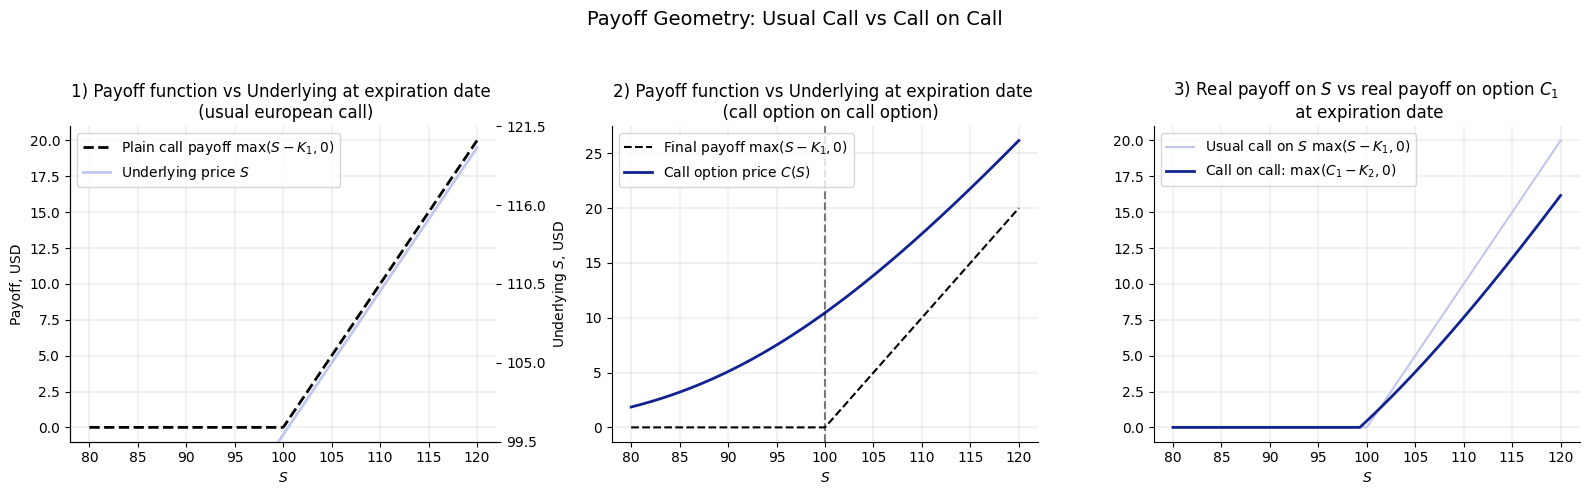

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from math import erf

colors = ["#c1c7efff", "#6376efff", "#112291ff"]

# =========================
# Vectorized normal CDF
# =========================
def norm_cdf(x):
    x = np.array(x, dtype=float)
    erf_vec = np.vectorize(erf)
    return 0.5 * (1 + erf_vec(x / np.sqrt(2)))

# =========================
# Parameters
# =========================
K1 = 100.0      # strike of the inner call
K2 = 10.0       # strike of the outer call (call on call)
K_plain = 100.0 # strike of the plain call

r = 0.05
sigma = 0.2
tau_inner = 1.0   # time to maturity (years)

S_min, S_max = 80, 120
n_points = 500
S = np.linspace(S_min, S_max, n_points)

# =========================
# Black–Scholes call price
# =========================
def bs_call_price(S, K, r, sigma, tau):
    S = np.array(S, dtype=float)

    if tau <= 0:
        return np.maximum(S - K, 0.0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm_cdf(d1) - K * np.exp(-r * tau) * norm_cdf(d2)

# =========================
# Payoffs
# =========================
def call_on_call_payoff_bs(S, K1, K2, r, sigma, tau_inner):
    """
    First value the inner call C_inner(S),
    then apply the outer payoff: max(C_inner - K2, 0)
    """
    C_inner = bs_call_price(S, K1, r, sigma, tau_inner)
    return np.maximum(C_inner - K2, 0.0), C_inner

def plain_call_payoff(S, K):
    return np.maximum(S - K, 0.0)

# Compute values
C_call_on_call, C_inner = call_on_call_payoff_bs(S, K1, K2, r, sigma, tau_inner)
C_plain_payoff = plain_call_payoff(S, K_plain)
C_plain_price  = bs_call_price(S, K_plain, r, sigma, tau_inner)

# =========================
# 3-panel figure
# =========================
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)

# ---------- Panel 1 ----------
ax1 = axes[0]

# Left axis: payoff
ax1.plot(S, C_plain_payoff, linewidth=2, color = "black", linestyle="--",
         label=r"Plain call payoff $\max(S-K_1,0)$")
ax1.set_ylabel("Payoff, USD", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Right axis: underlying
ax1b = ax1.twinx()
ax1b.plot(S, S, color = colors[0], linewidth=2,
          label="Underlying price $S$")
ax1b.set_ylabel("Underlying $S$, USD", color="black")
ax1b.tick_params(axis='y', labelcolor="black")


# ---------- Align both curves visually at the top ----------
payoff_min, payoff_max = ax1.get_ylim()
S_bottom = 99.5
S_top = S_bottom + (payoff_max - payoff_min)
ax1b.set_ylim(S_bottom, S_top)

ax1b.set_yticks(np.linspace(S_bottom, S_top, 5))

# ---------- Aesthetics ----------
ax1.set_title("1) Payoff function vs Underlying at expiration date \n (usual european call)", color="black")
ax1.set_xlabel("$S$", color="black")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# ---------- Panel 2 ----------
ax2 = axes[1]
ax2.plot(S, C_plain_payoff, linestyle="--", color= 'black',
         label=r"Final payoff $\max(S-K_1,0)$")
ax2.plot(S, C_plain_price, linewidth=2, color = colors[2],
         label=r"Call option price $C(S)$")

ax2.axvline(K_plain, color="black", linestyle="--", alpha=0.5)

ax2.set_title("2) Payoff function vs Underlying at expiration date \n  (call option on call option)", color="black")
ax2.set_xlabel("$S$", color="black")
ax2.legend()

# ---------- Panel 3 ----------
ax3 = axes[2]
ax3.plot(S, C_plain_payoff, color = colors[0], label="Usual call on $S$ $\max(S-K_1,0)$")
ax3.plot(S, C_call_on_call, color = colors[2], linewidth=2,
         label=r"Call on call: $\max(C_1-K_2,0)$")

ax3.set_title(f"3) Real payoff on $S$ vs real payoff on option $C_1$ \n at expiration date", color="black")
ax3.set_xlabel("$S$", color="black")
ax3.legend()

# ============================
# Apply visual style
# ============================
def beautify(ax):
    ax.grid(True, color="grey", linewidth=1.5, linestyle='-', alpha=0.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', colors="black")
    ax.tick_params(axis='y', colors="black")
    ax.title.set_color("black")
    ax.xaxis.label.set_color("black")
    ax.yaxis.label.set_color("black")

# apply to main panels
for ax in axes:
    beautify(ax)

# apply also to twin axis (panel 1)
beautify(ax1b)

ax1b.grid(False)

fig.suptitle("Payoff Geometry: Usual Call vs Call on Call", fontsize=14, color="black")
fig.tight_layout(rect=[0, 0, 1, 0.94])

plt.show()
# --- Save as PNG ---
fig.savefig("figures/2_payoff_geometry_usual_call_vs_call_on_call.png", dpi=300, bbox_inches="tight", transparent=False)

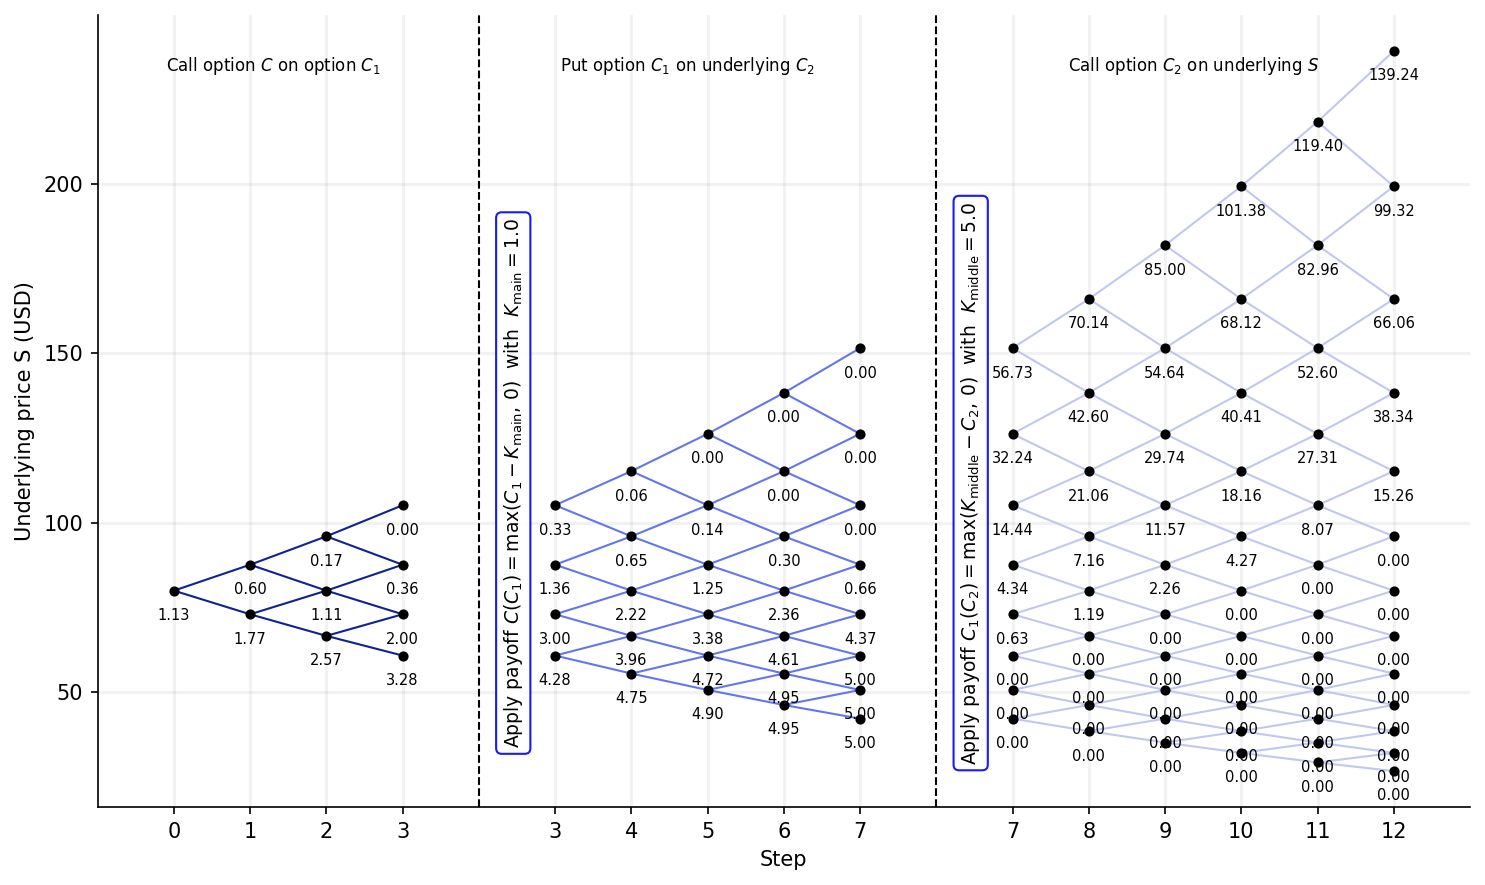

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Model parameters
# ==========================
colors = ["#c1c7efff", "#6376efff", "#112291ff"]  # left, middle, right blocks

S0 = 80.0
K_underlying  = 100.0   # strike of C2 on S
r  = 0.05
sigma = 0.20
T  = 2.5
N  = 12                 # number of time steps in the tree

# Option types
option_type_underlying = "call"   # C2(S)
option_type_middle     = "put"    # C1(C2)
option_type_main       = "call"   # C(C1)

# Strikes of the options on options
K_middle = 5.0   # strike of C1 on C2
K_main   = 1.0   # strike of C on C1

is_american = False

# Layers where payoffs of the options on options are applied
max_number_of_layers         = 3   # T1
max_number_of_layers_middle  = 7   # T2

L1 = max_number_of_layers
L2 = max_number_of_layers_middle

# ==========================
# CRR parameters
# ==========================
dt = T / N
u  = np.exp(sigma * np.sqrt(dt))
d  = 1.0 / u
disc = np.exp(-r * dt)
p = (np.exp(r * dt) - d) / (u - d)

# ==========================
# Stock price tree for S
# tree_S[i][j] = S at step i, state j
# ==========================
tree_S = [
    np.array([S0 * (u**j) * (d**(i - j)) for j in range(i + 1)], dtype=float)
    for i in range(N + 1)
]


# ==========================
# Payoff functions
# ==========================
def payoff_underlying(S):
    """Payoff of the underlying option C2(S)."""
    if option_type_underlying == "call":
        return np.maximum(S - K_underlying, 0.0)
    else:
        return np.maximum(K_underlying - S, 0.0)

def payoff_middle(x):
    """Payoff of the intermediate option C1(C2)."""
    if option_type_middle == "call":
        return np.maximum(x - K_middle, 0.0)
    else:
        return np.maximum(K_middle - x, 0.0)

def payoff_main(x):
    """Payoff of the main compound option C(C1)."""
    if option_type_main == "call":
        return np.maximum(x - K_main, 0.0)
    else:
        return np.maximum(K_main - x, 0.0)

# ==========================
# Right tree: C2 on S, 0..N
# ==========================
V2 = [np.zeros_like(level) for level in tree_S]
V2[N] = payoff_underlying(tree_S[N])

for i in range(N - 1, -1, -1):
    continuation = disc * (p * V2[i + 1][1:] + (1.0 - p) * V2[i + 1][:-1])
    if is_american:
        exercise = payoff_underlying(tree_S[i])
        V2[i] = np.maximum(continuation, exercise)
    else:
        V2[i] = continuation

# ==========================
# Middle tree: C1 on C2, 0..L2
# ==========================
V1 = [np.zeros_like(tree_S[i]) for i in range(L2 + 1)]
V1[L2] = payoff_middle(V2[L2])

for i in range(L2 - 1, -1, -1):
    continuation = disc * (p * V1[i + 1][1:] + (1.0 - p) * V1[i + 1][:-1])
    if is_american:
        exercise = payoff_middle(V2[i])
        V1[i] = np.maximum(continuation, exercise)
    else:
        V1[i] = continuation

# ==========================
# Left tree: C on C1, 0..L1
# ==========================
V0 = [np.zeros_like(tree_S[i]) for i in range(L1 + 1)]
V0[L1] = payoff_main(V1[L1])

for i in range(L1 - 1, -1, -1):
    continuation = disc * (p * V0[i + 1][1:] + (1.0 - p) * V0[i + 1][:-1])
    if is_american:
        exercise = payoff_main(V1[i])
        V0[i] = np.maximum(continuation, exercise)
    else:
        V0[i] = continuation

# ==========================
# PLOT: three separated blocks
# ==========================
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Horizontal offsets to visually separate the three blocks
offset_left   = 0
len_left      = L1             # number of visible steps in the left block

offset_middle = len_left + 2   # +2 for a gap / payoff box
len_middle    = L2 - L1        # visible steps in the middle block

offset_right  = offset_middle + len_middle + 2
len_right     = N - L2         # visible steps in the right block

# ---------- Left block: C on C1 (0..L1) ----------
for i in range(0, L1):
    x0_val = offset_left + i
    x1_val = offset_left + i + 1
    y0 = tree_S[i]
    y1 = tree_S[i + 1]

    for j in range(i + 1):
        # DOWN edge: (i, j) → (i+1, j)
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j]],
            color=colors[2], linewidth=1
        )
        # UP edge: (i, j) → (i+1, j+1)
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j + 1]],
            color=colors[2], linewidth=1
        )

for i in range(0, L1 + 1):
    x_val = offset_left + i
    y = tree_S[i]
    x = np.full(i + 1, x_val, dtype=float)
    ax.scatter(x, y, s=15, color="black", zorder=3)
    vals = V0[i]
    for (xx, yy), v in zip(zip(x, y), vals):
        ax.text(
            xx, yy,
            f"\n{v:.2f}",
            ha="center", va="top",
            fontsize=7, color="black"
        )

# ---------- Middle block: C1 on C2 (L1..L2) ----------
for i_global in range(L1, L2):
    i_loc = i_global - L1
    x0_val = offset_middle + i_loc
    x1_val = offset_middle + i_loc + 1
    y0 = tree_S[i_global]
    y1 = tree_S[i_global + 1]
    for j in range(i_global + 1):
        # DOWN edge
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j]],
            color=colors[1], linewidth=1
        )
        # UP edge
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j+1]],
            color=colors[1], linewidth=1
        )

for i_global in range(L1, L2 + 1):
    i_loc = i_global - L1
    x_val = offset_middle + i_loc
    y = tree_S[i_global]
    x = np.full(i_global + 1, x_val, dtype=float)
    ax.scatter(x, y, s=15, color="black", zorder=3)
    vals = V1[i_global]
    for (xx, yy), v in zip(zip(x, y), vals):
        ax.text(
            xx, yy,
            f"\n{v:.2f}",
            ha="center", va="top",
            fontsize=7, color="black"
        )

# ---------- Right block: C2 on S (L2..N) ----------
for i_global in range(L2, N):
    i_loc = i_global - L2
    x0_val = offset_right + i_loc
    x1_val = offset_right + i_loc + 1
    y0 = tree_S[i_global]
    y1 = tree_S[i_global + 1]

    for j in range(i_global + 1):
        # DOWN edge
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j]],
            color=colors[0], linewidth=1
        )
        # UP edge
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j+1]],
            color=colors[0], linewidth=1
        )

for i_global in range(L2, N + 1):
    i_loc = i_global - L2
    x_val = offset_right + i_loc
    y = tree_S[i_global]
    x = np.full(i_global + 1, x_val, dtype=float)
    ax.scatter(x, y, s=15, color="black", zorder=3)
    vals = V2[i_global]
    for (xx, yy), v in zip(zip(x, y), vals):
        ax.text(
            xx, yy,
            f"\n{v:.2f}",
            ha="center", va="top",
            fontsize=7, color="black"
        )

# ---------- Payoff separator lines between blocks + vertical labels ----------

y_min = min(level.min() for level in tree_S)
y_max = max(level.max() for level in tree_S)
y_mid = y_min + 0.4 * (y_max - y_min)   # convenient vertical position for text

# 1) Between left and middle blocks: payoff C(C1)
mid_payoff1 = offset_left + len_left + 1

ax.axvline(x=mid_payoff1, color="black", linestyle="--", linewidth=1)

# Formula depending on main option type C(C1)
if option_type_main == "call":
    payoff_formula_main = rf"$C(C_1)=\max(C_1 - K_{{\mathrm{{main}}}},\,0)$"
else:
    payoff_formula_main = rf"$C(C_1)=\max(K_{{\mathrm{{main}}}} - C_1,\,0)$"

payoff_text1 = rf"Apply payoff {payoff_formula_main}  with  $K_{{\mathrm{{main}}}}={K_main}$"

payoff_expl_text1 = ax.text(
    mid_payoff1 + 0.3,    # slightly to the right of the line
    y_mid,
    payoff_text1,
    ha="left",
    va="center",
    fontsize=9,
    rotation=90,
    bbox=dict(
        facecolor="white",
        edgecolor='blue',
        boxstyle="round,pad=0.3",
        linewidth=1.0,
        alpha=0.9,
    ),
)
payoff_expl_text1.set_visible(True)

# 2) Between middle and right blocks: payoff C1(C2)
mid_payoff2 = offset_middle + len_middle + 1

ax.axvline(x=mid_payoff2, color="black", linestyle="--", linewidth=1)

# Formula depending on middle option type C1(C2)
if option_type_middle == "call":
    payoff_formula_middle = rf"$C_1(C_2)=\max(C_2 - K_{{\mathrm{{middle}}}},\,0)$"
else:
    payoff_formula_middle = rf"$C_1(C_2)=\max(K_{{\mathrm{{middle}}}} - C_2,\,0)$"

payoff_text2 = rf"Apply payoff {payoff_formula_middle}  with  $K_{{\mathrm{{middle}}}}={K_middle}$"

payoff_expl_text2 = ax.text(
    mid_payoff2 + 0.3,
    y_mid,
    payoff_text2,
    ha="left",
    va="center",
    fontsize=9,
    rotation=90,
    bbox=dict(
        facecolor="white",
        edgecolor='blue',   # consistent with middle block color
        boxstyle="round,pad=0.3",
        linewidth=1.0,
        alpha=0.9,
    ),
)
payoff_expl_text2.set_visible(True)


# ---------- Overall aesthetics ----------
ax.set_xlabel("Step")
ax.set_ylabel("Underlying price S (USD)")

ax.grid(alpha=0.2)
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)


# ---------------------------------
# Boxes describing each option level
# ---------------------------------

# Left block: main compound option C on C1
left_option_text = rf"{option_type_main.capitalize()} option $C$ on option $C_1$"
left_option_box = ax.text(
    0.05, 0.95,
    left_option_text,
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=8,
)

# Middle block: C1 on C2
middle_option_text = rf"{option_type_middle.capitalize()} option $C_1$ on underlying $C_2$"
middle_option_box = ax.text(
    0.43, 0.95,
    middle_option_text,
    transform=ax.transAxes,
    ha="center",
    va="top",
    fontsize=8,
)

# Right block: C2 on S
right_option_text = rf"{option_type_underlying.capitalize()} option $C_2$ on underlying $S$"
right_option_box = ax.text(
    0.89, 0.95,
    right_option_text,
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=8,
)


# ======================================================
#        CUSTOM X–AXIS TICKS / LABELS (3 BLOCKS)
# ======================================================

# Left block 0..L1
left_steps = np.arange(0, L1 + 1)
left_tick_positions = offset_left + left_steps
left_tick_labels = [str(i) for i in left_steps]

# Middle block L1..L2
middle_len = L2 - L1
middle_steps = np.arange(0, middle_len + 1)
middle_tick_positions = offset_middle + middle_steps
middle_tick_labels = [str(i + L1) for i in middle_steps]

# Right block L2..N
right_len = N - L2
right_steps = np.arange(0, right_len + 1)
right_tick_positions = offset_right + right_steps
right_tick_labels = [str(i + L2) for i in right_steps]

# Combine all ticks and labels
xticks = np.concatenate([
    left_tick_positions,
    middle_tick_positions,
    right_tick_positions
])

xlabels = (
    left_tick_labels +
    middle_tick_labels +
    right_tick_labels
)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Adjust x-limits to include all blocks
ax.set_xlim(
    offset_left - 1,
    offset_right + right_len + 1
)

ax.grid(True, color="grey", linewidth=1.5, linestyle='-', alpha=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# --- Save as PNG ---
fig.savefig("figures/2_call_on_put_on_call_3_layers_logic.png", dpi=300, bbox_inches="tight", transparent=False)


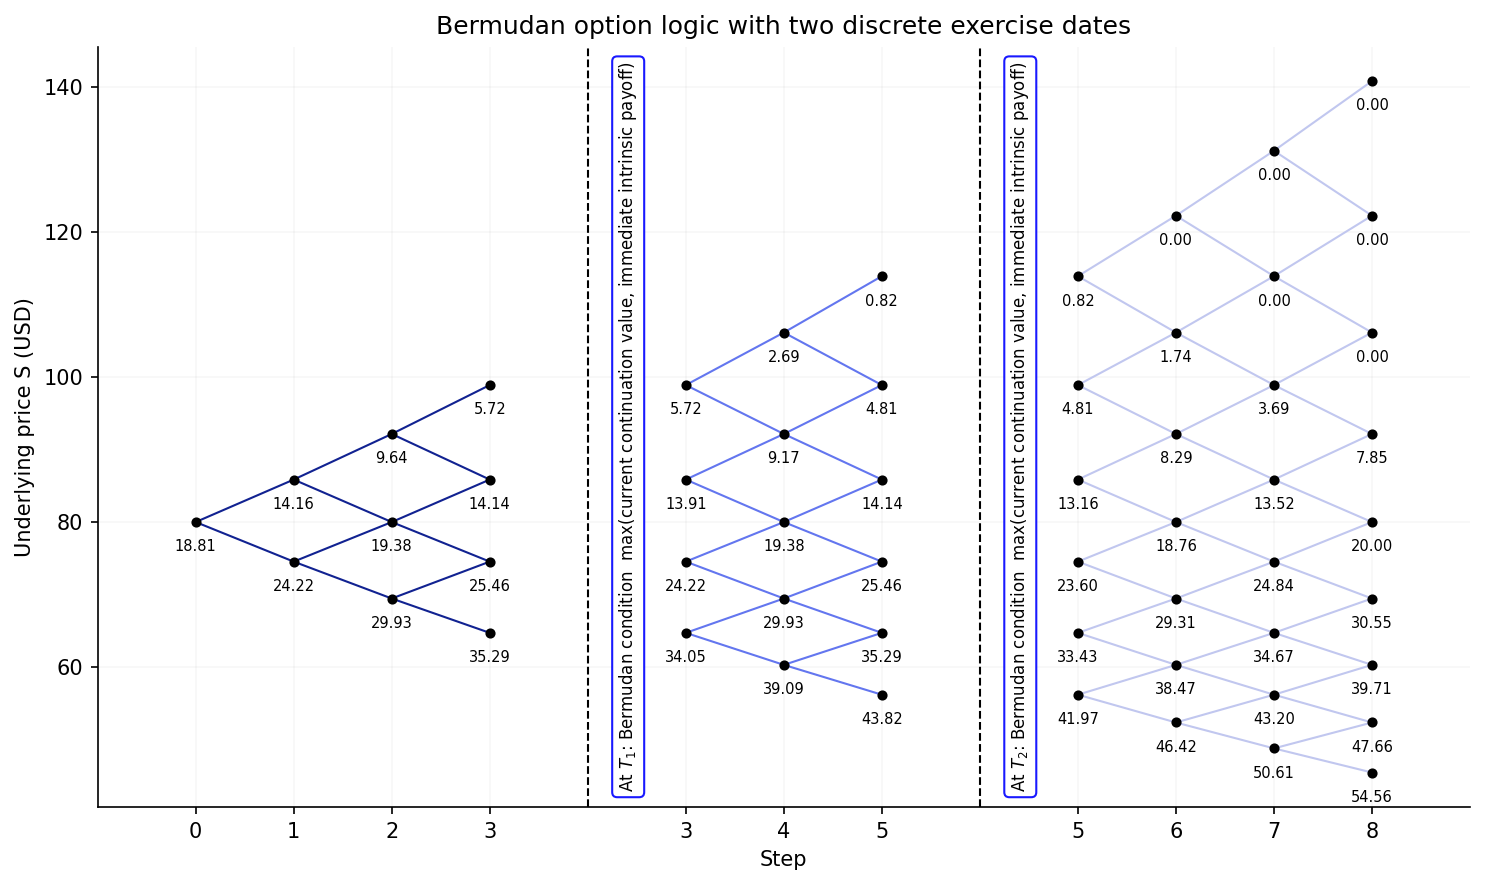

In [13]:
# It is essentially a modified version of the option-on-option graph
# to illustrate the structure of a Bermudan option.
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Model parameters
# ==========================
colors = ["#c1c7efff", "#6376efff", "#112291ff"]  # left, middle, right blocks

S0 = 80.0
K_underlying  = 100.0   # strike of the Bermudan option on S
r  = 0.05
sigma = 0.20
T  = 1.0
N  = 8                  # number of time steps in the tree

# Type of underlying option
option_type_underlying = "put"   # Bermudan put on S

# These are only used for the top text labels (not for the pricing logic)
option_type_middle = option_type_underlying
option_type_main   = option_type_underlying

# Strikes of “layers” (not used explicitly, we always use K_underlying)
K_middle = 0.0
K_main   = 0.0

is_american = False

# Bermudan exercise dates (in time steps)
max_number_of_layers         = 3   # T1
max_number_of_layers_middle  = 5   # T2

L1 = max_number_of_layers
L2 = max_number_of_layers_middle

# ==========================
# CRR parameters
# ==========================
dt = T / N
u  = np.exp(sigma * np.sqrt(dt))
d  = 1.0 / u
disc = np.exp(-r * dt)
p = (np.exp(r * dt) - d) / (u - d)

# ==========================
# Stock price tree for S
# tree_S[i][j] = S at step i, state j
# ==========================
tree_S = [
    np.array([S0 * (u**j) * (d**(i - j)) for j in range(i + 1)], dtype=float)
    for i in range(N + 1)
]

# ==========================
# Underlying payoff (put/call)
# ==========================
def payoff_underlying(S):
    if option_type_underlying == "call":
        return np.maximum(S - K_underlying, 0.0)
    else:
        return np.maximum(K_underlying - S, 0.0)

# ==========================
# Right tree: European (no early exercise) → V2
# ==========================
V2 = [np.zeros_like(level) for level in tree_S]
V2[N] = payoff_underlying(tree_S[N])

for i in range(N - 1, -1, -1):
    continuation = disc * (p * V2[i + 1][1:] + (1.0 - p) * V2[i + 1][:-1])
    V2[i] = continuation

# ==========================
# Middle tree: Bermudan with exercise allowed at T2 → V1
# Condition at T2: V1[L2] = max(European continuation V2[L2], immediate payoff)
# ==========================
V1 = [np.zeros_like(tree_S[i]) for i in range(L2 + 1)]
V1[L2] = np.maximum(V2[L2], payoff_underlying(tree_S[L2]))

for i in range(L2 - 1, -1, -1):
    continuation = disc * (p * V1[i + 1][1:] + (1.0 - p) * V1[i + 1][:-1])
    V1[i] = continuation

# ==========================
# Left tree: Bermudan with exercise allowed at T1 and T2 → V0
# Condition at T1: V0[L1] = max(V1[L1], immediate payoff)
# ==========================
V0 = [np.zeros_like(tree_S[i]) for i in range(L1 + 1)]
V0[L1] = np.maximum(V1[L1], payoff_underlying(tree_S[L1]))

for i in range(L1 - 1, -1, -1):
    continuation = disc * (p * V0[i + 1][1:] + (1.0 - p) * V0[i + 1][:-1])
    V0[i] = continuation

# ==========================
# PLOT: three separated blocks
# ==========================
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Horizontal offsets to visually separate the blocks
offset_left   = 0
len_left      = L1             # visible steps in the left block

offset_middle = len_left + 2   # +2 to leave a gap / condition box
len_middle    = L2 - L1        # visible steps in the middle block

offset_right  = offset_middle + len_middle + 2
len_right     = N - L2         # visible steps in the right block

# ---------- Left block: V0 (Bermudan with exercise at T1 and T2) ----------
for i in range(0, L1):
    x0_val = offset_left + i
    x1_val = offset_left + i + 1
    y0 = tree_S[i]
    y1 = tree_S[i + 1]

    for j in range(i + 1):
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j]],
            color=colors[2], linewidth=1
        )
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j + 1]],
            color=colors[2], linewidth=1
        )

for i in range(0, L1 + 1):
    x_val = offset_left + i
    y = tree_S[i]
    x = np.full(i + 1, x_val, dtype=float)
    ax.scatter(x, y, s=15, color="black", zorder=3)
    vals = V0[i]
    for (xx, yy), v in zip(zip(x, y), vals):
        ax.text(
            xx, yy,
            f"\n{v:.2f}",
            ha="center", va="top",
            fontsize=7, color="black"
        )

# ---------- Middle block: V1 (Bermudan with exercise only at T2) ----------
for i_global in range(L1, L2):
    i_loc = i_global - L1
    x0_val = offset_middle + i_loc
    x1_val = offset_middle + i_loc + 1
    y0 = tree_S[i_global]
    y1 = tree_S[i_global + 1]
    for j in range(i_global + 1):
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j]],
            color=colors[1], linewidth=1
        )
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j+1]],
            color=colors[1], linewidth=1
        )

for i_global in range(L1, L2 + 1):
    i_loc = i_global - L1
    x_val = offset_middle + i_loc
    y = tree_S[i_global]
    x = np.full(i_global + 1, x_val, dtype=float)
    ax.scatter(x, y, s=15, color="black", zorder=3)
    vals = V1[i_global]
    for (xx, yy), v in zip(zip(x, y), vals):
        ax.text(
            xx, yy,
            f"\n{v:.2f}",
            ha="center", va="top",
            fontsize=7, color="black"
        )

# ---------- Right block: V2 (pure European, no early exercise) ----------
for i_global in range(L2, N):
    i_loc = i_global - L2
    x0_val = offset_right + i_loc
    x1_val = offset_right + i_loc + 1
    y0 = tree_S[i_global]
    y1 = tree_S[i_global + 1]

    for j in range(i_global + 1):
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j]],
            color=colors[0], linewidth=1
        )
        ax.plot(
            [x0_val, x1_val],
            [y0[j], y1[j+1]],
            color=colors[0], linewidth=1
        )

for i_global in range(L2, N + 1):
    i_loc = i_global - L2
    x_val = offset_right + i_loc
    y = tree_S[i_global]
    x = np.full(i_global + 1, x_val, dtype=float)
    ax.scatter(x, y, s=15, color="black", zorder=3)
    vals = V2[i_global]
    for (xx, yy), v in zip(zip(x, y), vals):
        ax.text(
            xx, yy,
            f"\n{v:.2f}",
            ha="center", va="top",
            fontsize=7, color="black"
        )

# ---------- Bermudan exercise-condition lines + vertical labels ----------
y_min = min(level.min() for level in tree_S)
y_max = max(level.max() for level in tree_S)
y_mid = y_min + 0.5 * (y_max - y_min)

# Intrinsic payoff formula in LaTeX (not explicitly used below)
if option_type_underlying == "call":
    payoff_intrinsic = rf"$\max(S-K_{{\mathrm{{under}}}},0)$"
else:
    payoff_intrinsic = rf"$\max(K_{{\mathrm{{under}}}}-S,0)$"

# Between left and middle blocks: exercise date T1
mid_payoff1 = offset_left + len_left + 1
ax.axvline(x=mid_payoff1, color="black", linestyle="--", linewidth=1)

payoff_text1 = (
    r"At $T_1$: Bermudan condition  "
    r"max(current continuation value, immediate intrinsic payoff)"
)

ax.text(
    mid_payoff1 + 0.3,
    y_mid,
    payoff_text1,
    ha="left",
    va="center",
    fontsize=8,
    rotation=90,
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        linewidth=1.0,
        alpha=0.9,
    ),
)

# Between middle and right blocks: exercise date T2
mid_payoff2 = offset_middle + len_middle + 1
ax.axvline(x=mid_payoff2, color="black", linestyle="--", linewidth=1)

payoff_text2 = (
    r"At $T_2$: Bermudan condition  "
    r"max(current continuation value, immediate intrinsic payoff)"
)

ax.text(
    mid_payoff2 + 0.3,
    y_mid,
    payoff_text2,
    ha="left",
    va="center",
    fontsize=8,
    rotation=90,
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        linewidth=1.0,
        alpha=0.9,
    ),
)

# ---------- Overall aesthetics ----------
ax.set_xlabel("Step")
ax.set_ylabel("Underlying price S (USD)")

ax.grid(alpha=0.1, linestyle='-')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# ======================================================
#        CUSTOM X–AXIS TICKS / LABELS (3 BLOCKS)
# ======================================================
left_steps = np.arange(0, L1 + 1)
left_tick_positions = offset_left + left_steps
left_tick_labels = [str(i) for i in left_steps]

middle_len = L2 - L1
middle_steps = np.arange(0, middle_len + 1)
middle_tick_positions = offset_middle + middle_steps
middle_tick_labels = [str(i + L1) for i in middle_steps]

right_len = N - L2
right_steps = np.arange(0, right_len + 1)
right_tick_positions = offset_right + right_steps
right_tick_labels = [str(i + L2) for i in right_steps]

xticks = np.concatenate([
    left_tick_positions,
    middle_tick_positions,
    right_tick_positions
])
xlabels = left_tick_labels + middle_tick_labels + right_tick_labels

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

ax.set_xlim(offset_left - 1, offset_right + right_len + 1)
ax.set_title("Bermudan option logic with two discrete exercise dates")

plt.tight_layout()
plt.show()
# --- Save as PNG ---
fig.savefig("figures/2_bermudian_option_logic.png", dpi=300, bbox_inches="tight", transparent=False)

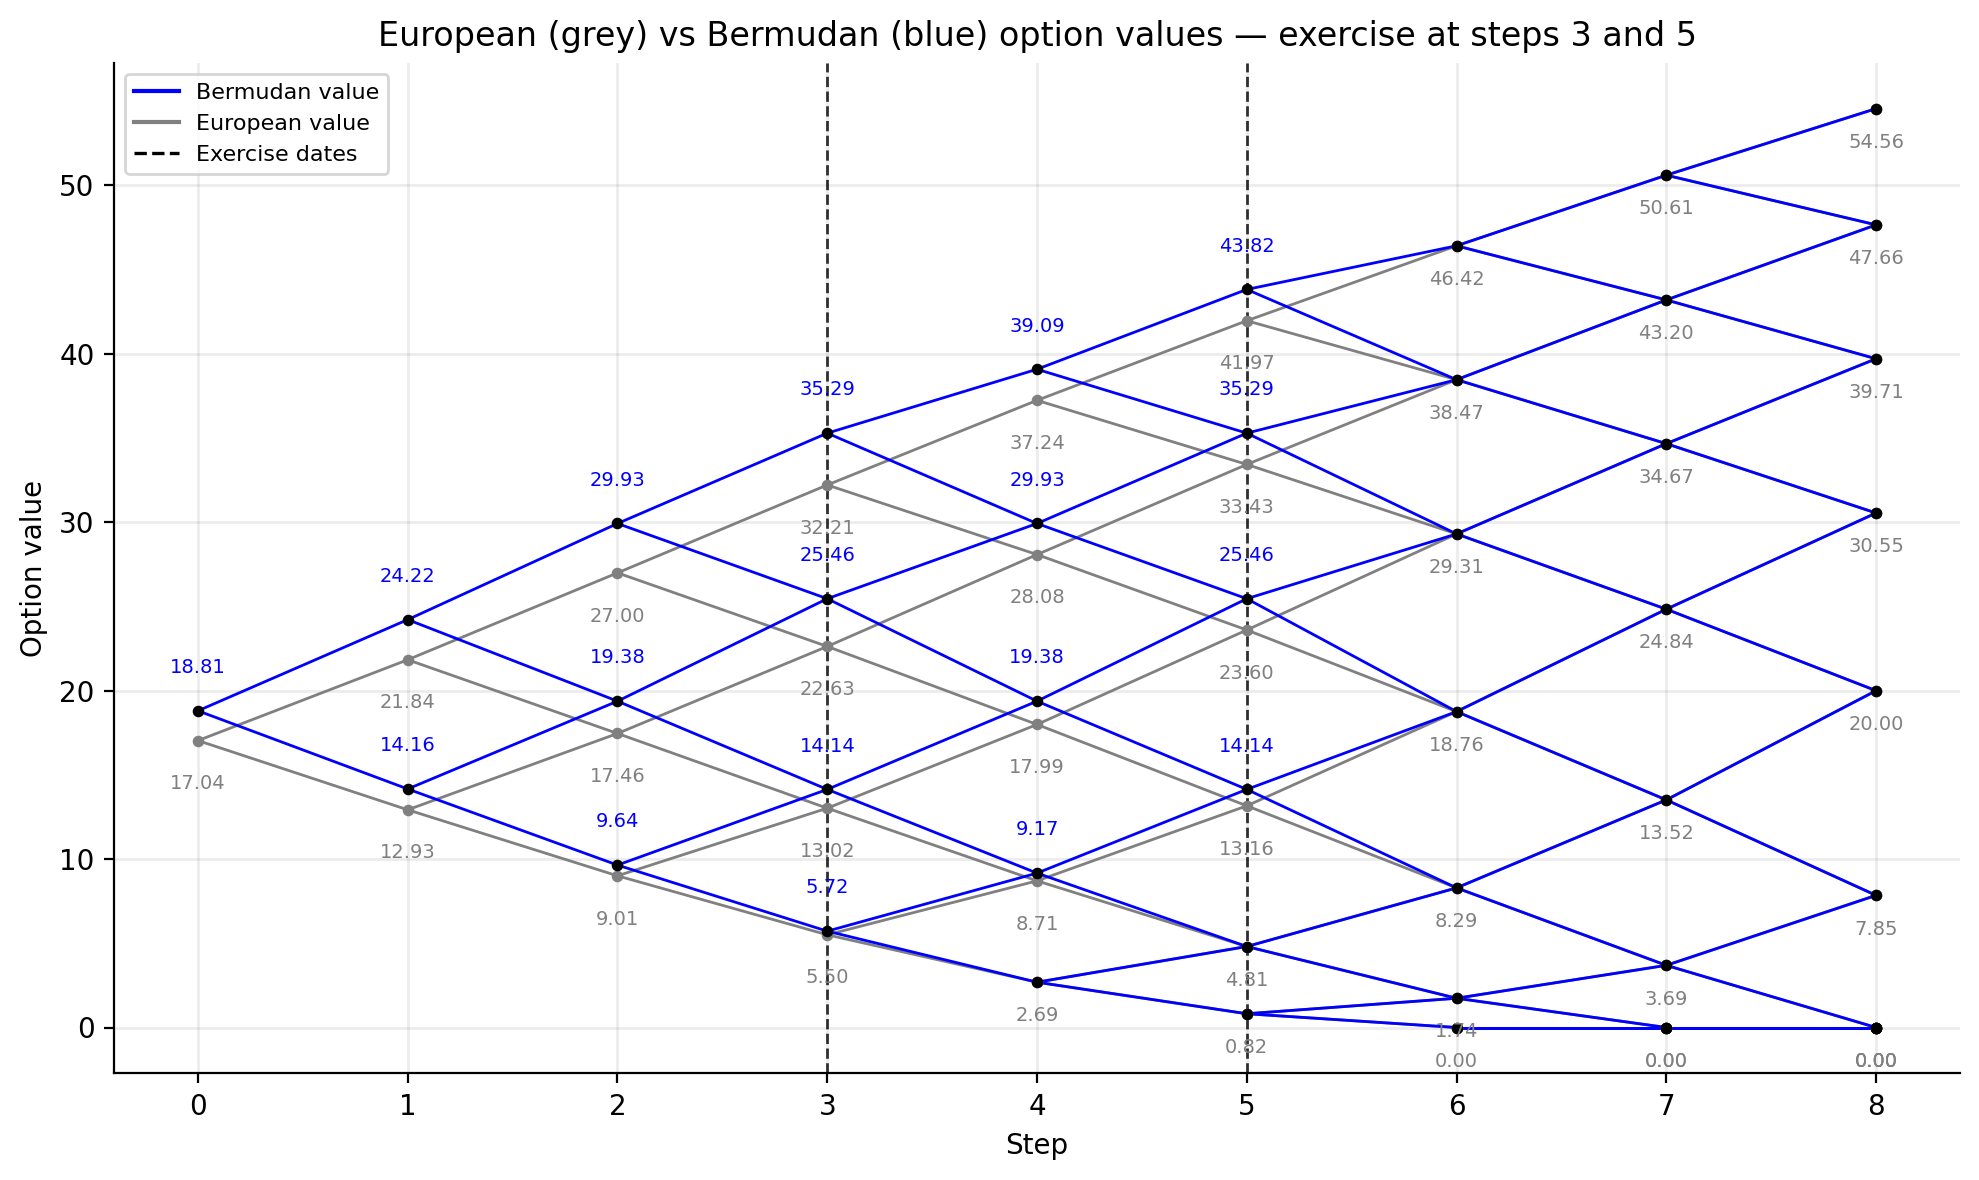

In [14]:
# Binomial (CRR) tree: European vs Bermudan (2 exercise dates)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

colors = ["#c1c7efff", "#6376efff", "#112291ff"]

# ==========================
# Model parameters
# ==========================
S0 = 80.0
K  = 100.0
r  = 0.05
sigma = 0.20
T  = 1.0
N  = 8

option_type = "put"   # we use a put, consistent with the previous example

# Bermudan exercise dates (in time steps)
L1 = 3   # first exercise date
L2 = 5   # second exercise date

# ==========================
# CRR parameters
# ==========================
dt = T / N
u  = np.exp(sigma * np.sqrt(dt))
d  = 1.0 / u
disc = np.exp(-r * dt)
p = (np.exp(r * dt) - d) / (u - d)

# ==========================
# Stock price tree S
# ==========================
tree_S = [
    np.array([S0 * (u**j) * (d**(i-j)) for j in range(i+1)], dtype=float)
    for i in range(N+1)
]

def payoff_fn(S):
    """Payoff function for the underlying option (call/put)."""
    if option_type == "call":
        return np.maximum(S - K, 0.0)
    else:
        return np.maximum(K - S, 0.0)

# ==========================
# European option tree
# ==========================
tree_V_eur = [np.zeros_like(level) for level in tree_S]
tree_V_eur[-1] = payoff_fn(tree_S[-1])

for i in range(N-1, -1, -1):
    continuation = disc * (
        p * tree_V_eur[i+1][1:] + (1.0 - p) * tree_V_eur[i+1][:-1]
    )
    tree_V_eur[i] = continuation

price_eur = float(tree_V_eur[0][0])

# ==========================
# Bermudan option tree (2 exercise dates)
# ==========================
tree_V_ber = [np.zeros_like(level) for level in tree_S]
tree_V_ber[-1] = payoff_fn(tree_S[-1])

for i in range(N-1, -1, -1):
    continuation = disc * (
        p * tree_V_ber[i+1][1:] + (1.0 - p) * tree_V_ber[i+1][:-1]
    )
    exercise = payoff_fn(tree_S[i])

    # Only at L1 and L2 is early exercise allowed
    if i in (L1, L2):
        tree_V_ber[i] = np.maximum(continuation, exercise)
    else:
        tree_V_ber[i] = continuation

price_ber = float(tree_V_ber[0][0])

# ==========================
# PLOT: Option value tree (not the S tree!)
# ==========================
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# Edges: we use the European values to define the geometry of the tree
for i in range(N):
    x0 = np.full(i+1, i)
    v0 = tree_V_eur[i]
    x1 = np.full(i+2, i+1)
    v1 = tree_V_eur[i+1]

    # Draw grey "reference" tree for European option
    for j in range(i+1):
        # Down edge
        ax.plot(
            [x0[j], x1[j]],
            [v0[j], v1[j]],
            color='grey',
            linewidth=1
        )
        # Up edge
        ax.plot(
            [x0[j], x1[j+1]],
            [v0[j], v1[j+1]],
            color='grey',
            linewidth=1
        )

    # Overlay Bermudan tree on top in blue
    v0 = tree_V_ber[i]
    v1 = tree_V_ber[i+1]
    for j in range(i+1):
        # Down edge
        ax.plot(
            [x0[j], x1[j]],
            [v0[j], v1[j]],
            color='blue',
            linewidth=1
        )
        # Up edge
        ax.plot(
            [x0[j], x1[j+1]],
            [v0[j], v1[j+1]],
            color='blue',
            linewidth=1
        )

# Nodes + numeric labels
for i in range(N+1):
    x = np.full(i+1, i)
    v_eur = tree_V_eur[i]
    v_ber = tree_V_ber[i]

    # Nodes: grey for European, black for Bermudan
    ax.scatter(x, v_eur, s=10, color='grey', zorder=3)
    ax.scatter(x, v_ber, s=10, color='black', zorder=3)

    for j in range(i+1):
        e = v_eur[j]
        b = v_ber[j]

        if abs(e - b) < 1e-10:
            # Same value: show only the European one
            ax.text(
                x[j], e - 2,
                f"{e:.2f}",
                ha='center', va='center',
                fontsize=7, color='grey'
            )
        else:
            # Bermudan value (above)
            ax.text(
                x[j], b + 2,
                f"{b:.2f}",
                ha='center', va='bottom',
                fontsize=7, color='blue'
            )
            # European value (below)
            ax.text(
                x[j], e - 2,
                f"{e:.2f}",
                ha='center', va='top',
                fontsize=7, color='grey'
            )

# ==========================
# Vertical lines for Bermudan exercise dates
# ==========================
for step in (L1, L2):
    ax.axvline(
        x=step,
        color='black',
        linestyle='--',
        linewidth=1.0,
        alpha=0.8
    )

# Legend
legend_elements = [
    Line2D([0], [0], color='blue', linestyle='-',
           label='Bermudan value', markersize=6),
    Line2D([0], [0], color='grey', linestyle='-',
           label='European value', markersize=6),
    Line2D([0], [0], color='black', linestyle='--',
           label='Exercise dates', linewidth=1.2),
]

ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

# Titles and axes labels
ax.set_title(
    f"European (grey) vs Bermudan (blue) option values — exercise at steps {L1} and {L2}"
)
ax.set_xlabel("Step")
ax.set_ylabel("Option value")

ax.grid(True, color="grey", linewidth=1.0, linestyle='-', alpha=0.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
# --- Save as PNG ---
fig.savefig("figures/2_bermudian_european_compare.png", dpi=300, bbox_inches="tight", transparent=False)

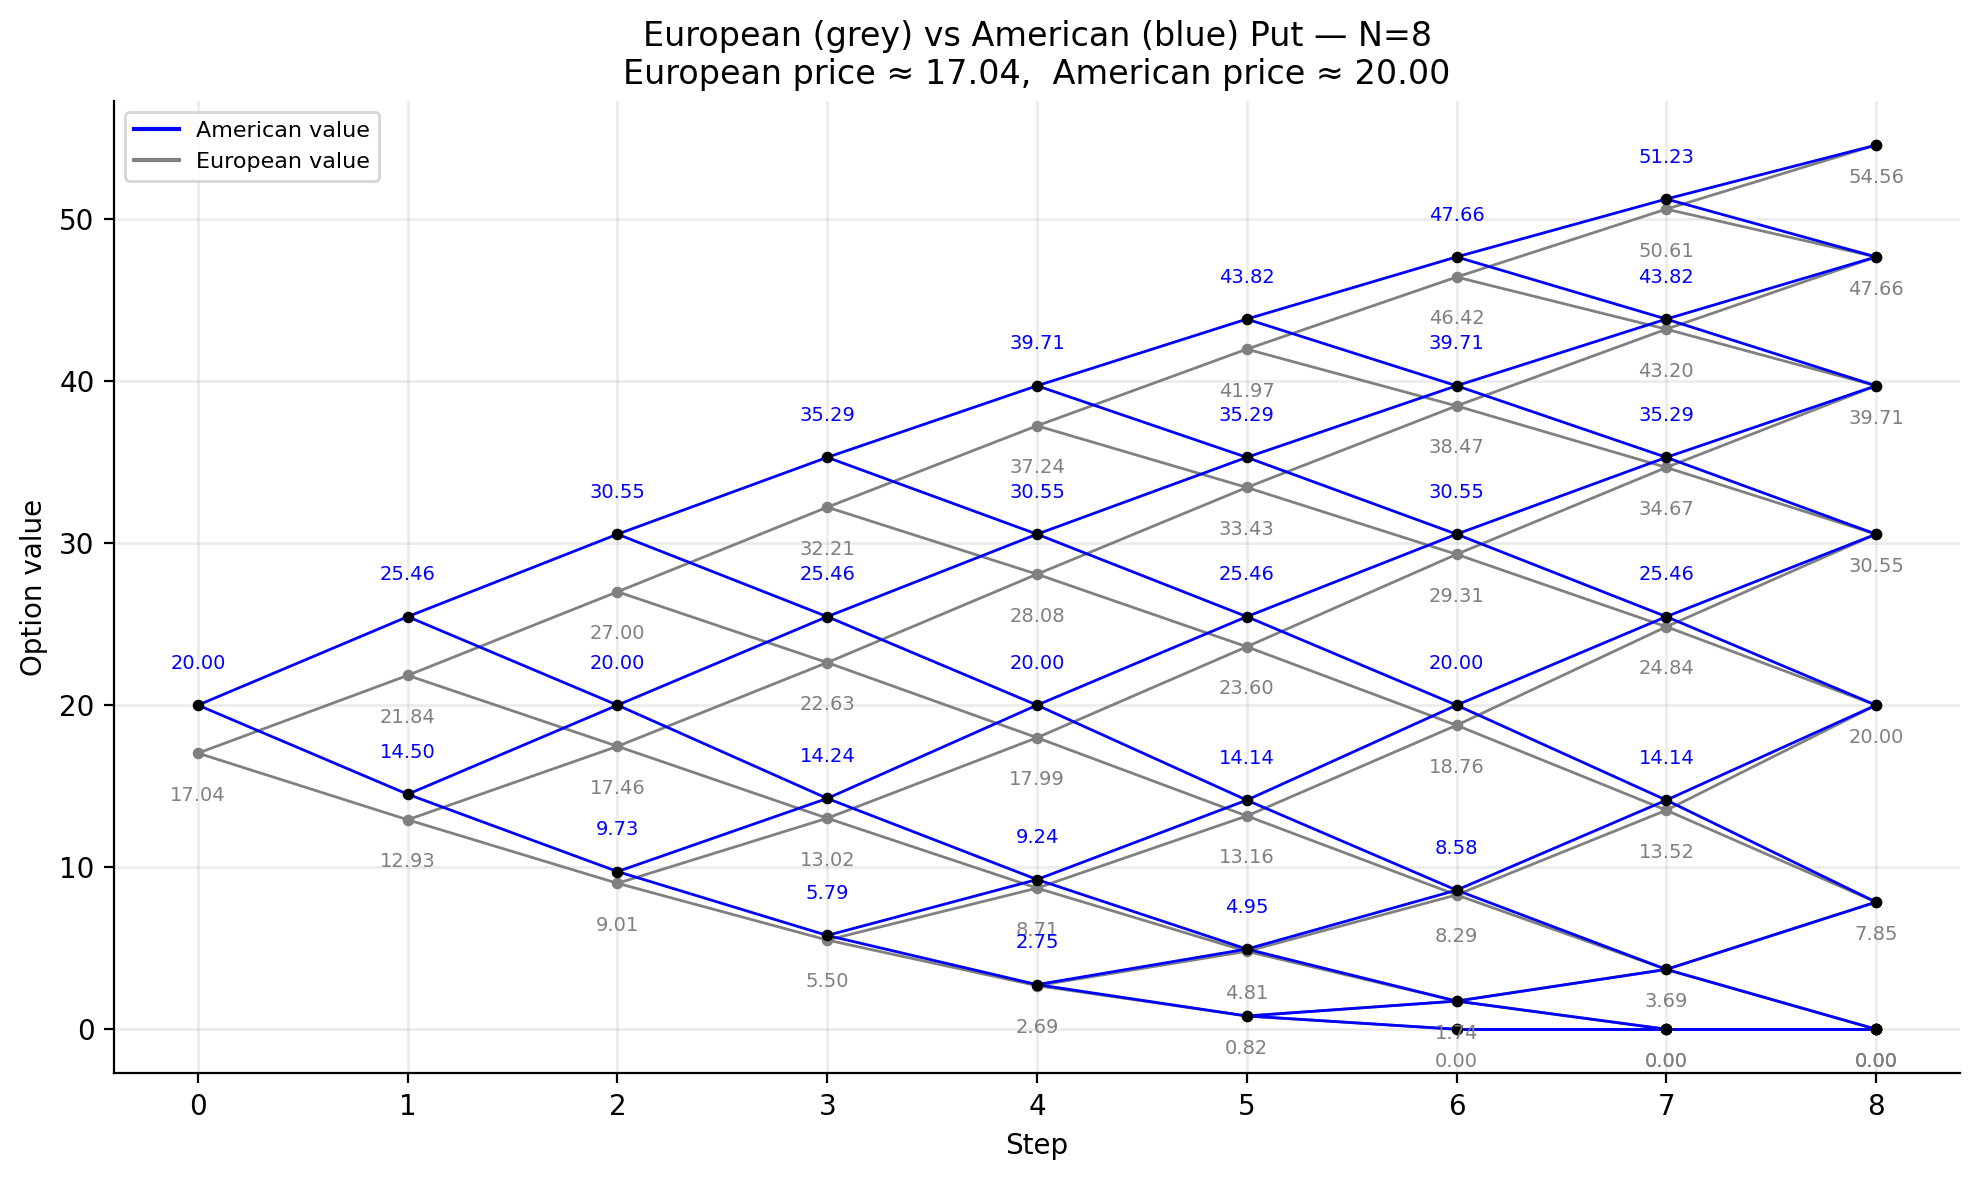

In [18]:
# Binomial (CRR) tree: European vs American
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

colors = ["#c1c7efff", "#6376efff", "#112291ff"]

# ==========================
# Model parameters
# ==========================
S0 = 80.0
K  = 100.0
r  = 0.05
sigma = 0.20
T  = 1.0
N  = 8

option_type = "put"   # "call" or "put"

# ==========================
# CRR parameters
# ==========================
dt = T / N
u  = np.exp(sigma * np.sqrt(dt))
d  = 1.0 / u
disc = np.exp(-r * dt)
p = (np.exp(r * dt) - d) / (u - d)

# ==========================
# Stock price tree S
# ==========================
tree_S = [
    np.array([S0 * (u**j) * (d**(i-j)) for j in range(i+1)], dtype=float)
    for i in range(N+1)
]

def payoff_fn(S):
    """Payoff of the underlying option."""
    if option_type == "call":
        return np.maximum(S - K, 0.0)
    else:
        return np.maximum(K - S, 0.0)

# ==========================
# European option tree
# ==========================
tree_V_eur = [np.zeros_like(level) for level in tree_S]
tree_V_eur[-1] = payoff_fn(tree_S[-1])

for i in range(N-1, -1, -1):
    continuation = disc * (
        p * tree_V_eur[i+1][1:] + (1.0 - p) * tree_V_eur[i+1][:-1]
    )
    tree_V_eur[i] = continuation

price_eur = float(tree_V_eur[0][0])

# ==========================
# American option tree
# ==========================
tree_V_am = [np.zeros_like(level) for level in tree_S]
tree_V_am[-1] = payoff_fn(tree_S[-1])

for i in range(N-1, -1, -1):
    continuation = disc * (
        p * tree_V_am[i+1][1:] + (1.0 - p) * tree_V_am[i+1][:-1]
    )
    exercise = payoff_fn(tree_S[i])
    # American: early exercise is allowed at *every* time step
    tree_V_am[i] = np.maximum(continuation, exercise)

price_am = float(tree_V_am[0][0])

# ==========================
# PLOT: Option value tree
# ==========================

fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# Edges (we draw both lattices: European in grey and American in blue)
for i in range(N):
    x0 = np.full(i+1, i)
    x1 = np.full(i+2, i+1)

    # European edges
    v0_e = tree_V_eur[i]
    v1_e = tree_V_eur[i+1]
    for j in range(i+1):
        ax.plot(
            [x0[j], x1[j]],
            [v0_e[j], v1_e[j]],
            color='grey',
            linewidth=1
        )
        ax.plot(
            [x0[j], x1[j+1]],
            [v0_e[j], v1_e[j+1]],
            color='grey',
            linewidth=1
        )

    # American edges
    v0_a = tree_V_am[i]
    v1_a = tree_V_am[i+1]
    for j in range(i+1):
        ax.plot(
            [x0[j], x1[j]],
            [v0_a[j], v1_a[j]],
            color='blue',
            linewidth=1
        )
        ax.plot(
            [x0[j], x1[j+1]],
            [v0_a[j], v1_a[j+1]],
            color='blue',
            linewidth=1
        )

# Nodes + numeric labels
for i in range(N+1):
    x = np.full(i+1, i)
    v_eur = tree_V_eur[i]
    v_am  = tree_V_am[i]

    # base points (European)
    ax.scatter(x, v_eur, s=10, color='grey', zorder=3)
    # American points on top (black markers for nodes)
    ax.scatter(x, v_am,  s=10, color='black', zorder=3)

    for j in range(i+1):
        e = v_eur[j]
        a = v_am[j]

        if abs(e - a) < 1e-10:
            # SAME: show only the European value
            ax.text(
                x[j], e - 2,
                f"{e:.2f}",
                ha='center', va='center',
                fontsize=7, color='grey'
            )
        else:
            # American value (above)
            ax.text(
                x[j], a + 2,
                f"{a:.2f}",
                ha='center', va='bottom',
                fontsize=7, color='blue'
            )
            # European value (below)
            ax.text(
                x[j], e - 2,
                f"{e:.2f}",
                ha='center', va='top',
                fontsize=7, color='grey'
            )

# ==========================
# Legend
# ==========================
legend_elements = [
    Line2D([0], [0], color='blue', linestyle='-',
           label='American value', markersize=6),
    Line2D([0], [0], color='grey', linestyle='-',
           label='European value', markersize=6),
]

ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

# Titles and labels
ax.set_title(
    f"European (grey) vs American (blue) {option_type.capitalize()} — N={N}\n"
    f"European price ≈ {price_eur:.2f},  American price ≈ {price_am:.2f}"
)
ax.set_xlabel("Step")
ax.set_ylabel("Option value")

ax.grid(True, color="grey", linewidth=1.0, linestyle='-', alpha=0.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
# --- Save as PNG ---
fig.savefig("figures/2_american_european_compare.png", dpi=300, bbox_inches="tight", transparent=False)

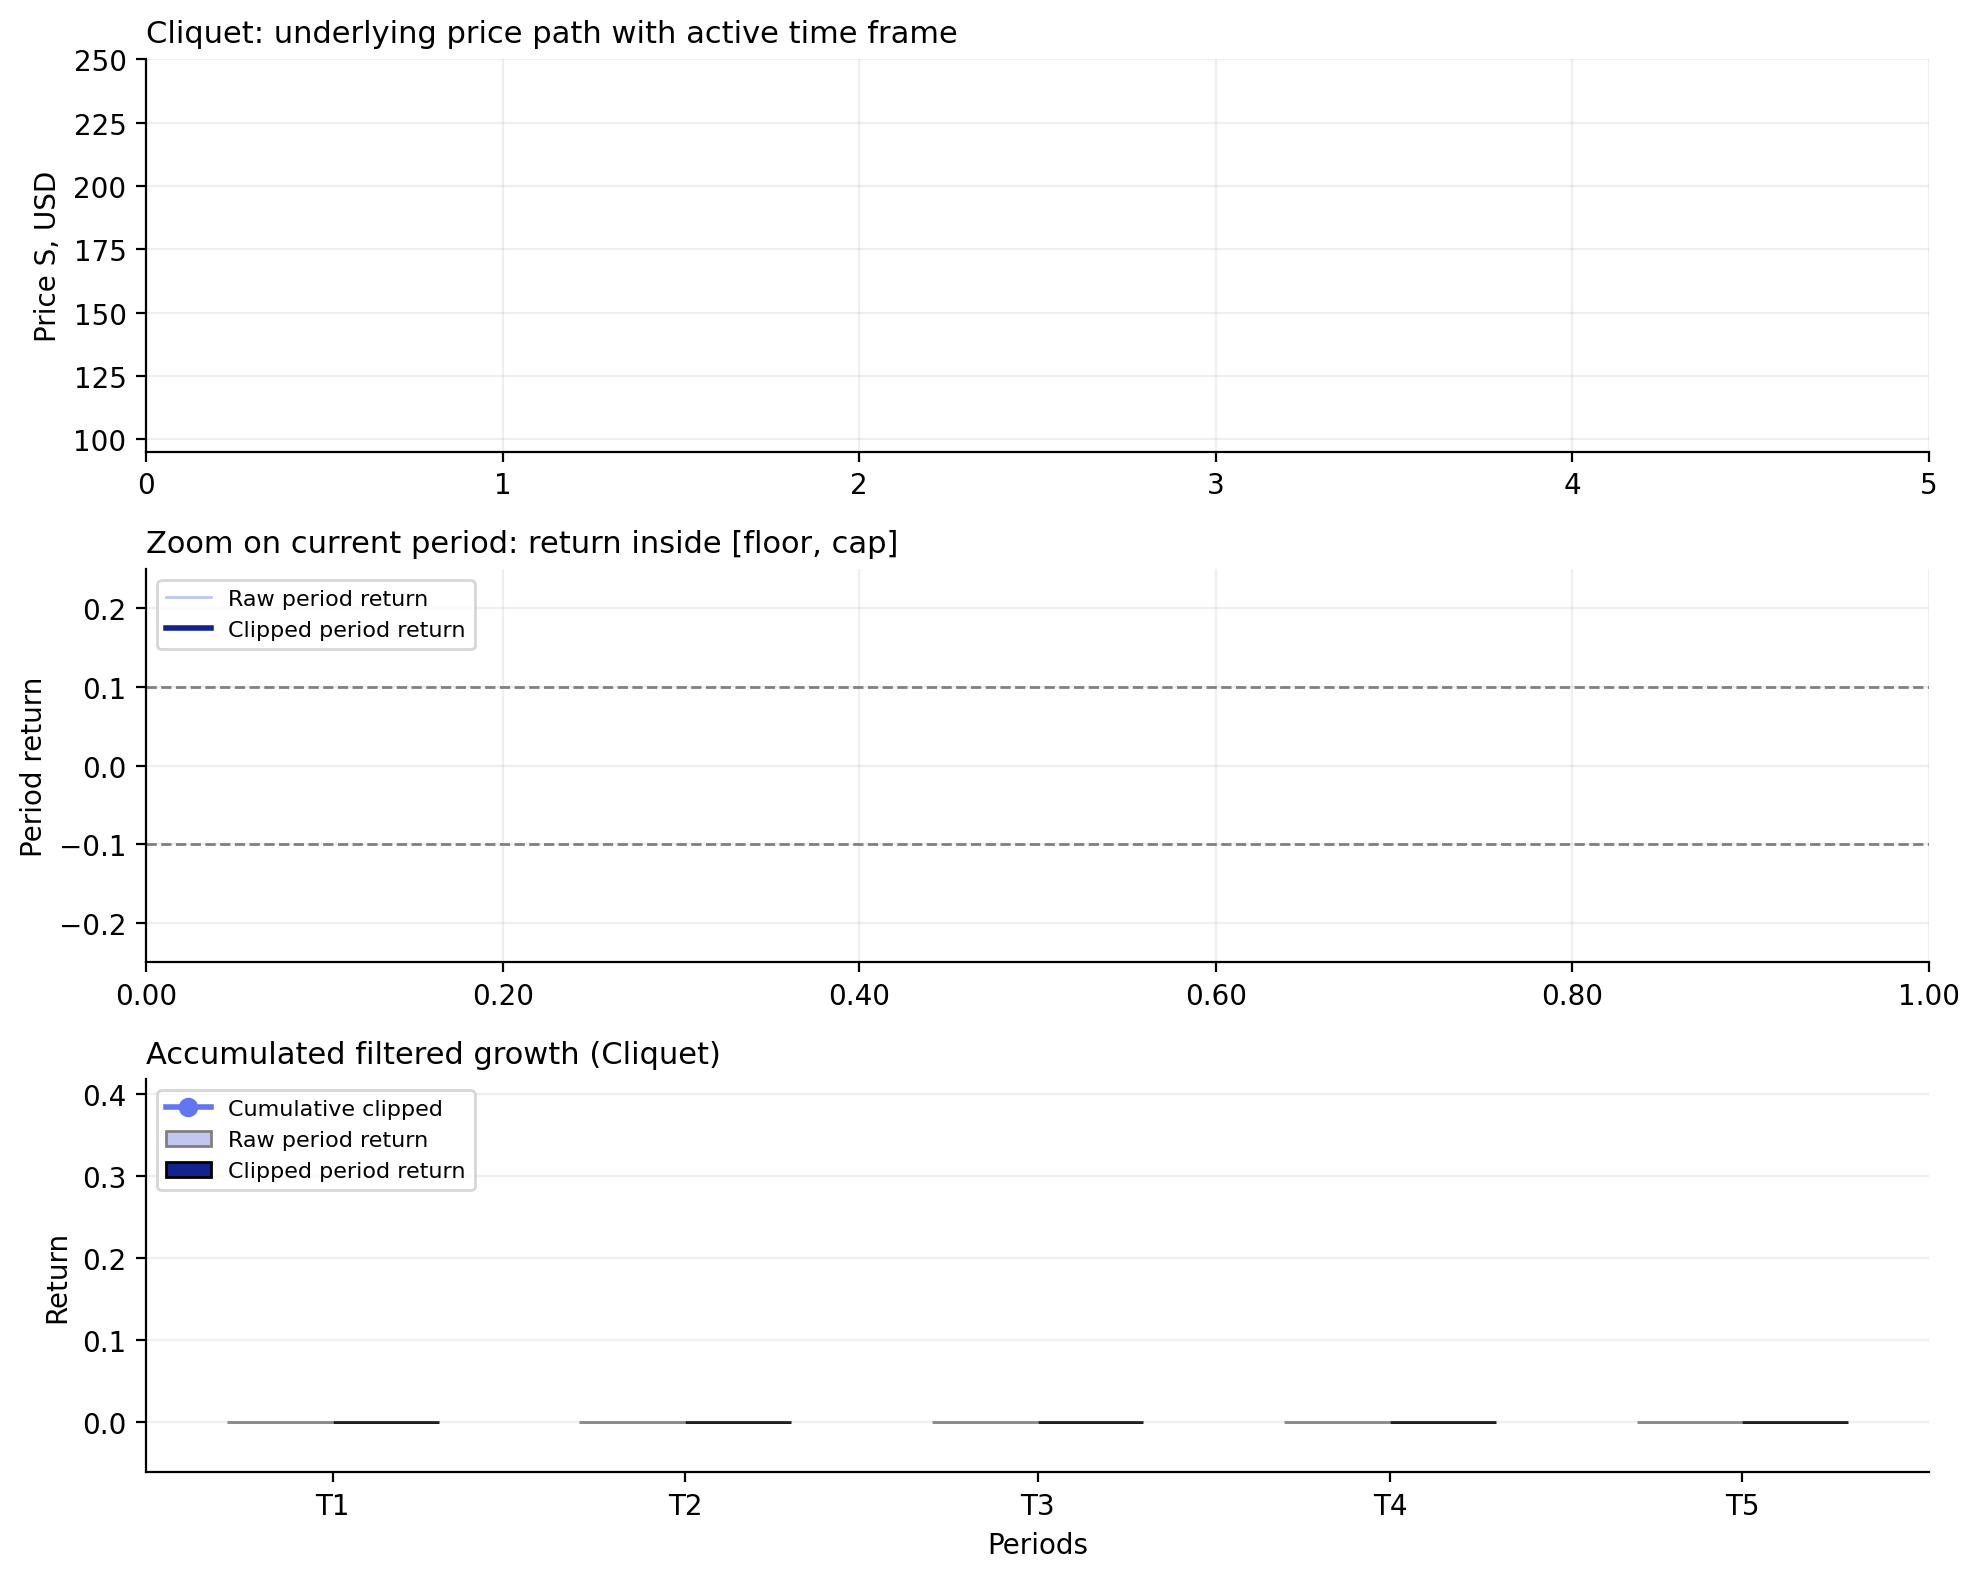

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.ticker import FuncFormatter

colors = ["#c1c7efff", "#6376efff", "#112291ff"]

# ===========================
# Basic parameters
# ===========================
np.random.seed(18)

n_periods = 5
steps_per_period = 20
n_steps = n_periods * steps_per_period      # total time steps

T = n_periods
t = np.linspace(0.0, T, n_steps + 1)        # 0..T (n_steps+1 points)
S0 = 100.0
K  = 100.0   # strike used in the final payoff comment

# Smooth GBM-like path for visualization
mu = 0.01
sigma = 0.2
dt = T / n_steps
dW = np.sqrt(dt) * np.random.normal(size=n_steps)
S = np.zeros(n_steps + 1)
S[0] = S0
for i in range(n_steps):
    S[i+1] = S[i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[i])

# ===========================
# Cliquet parameters
# ===========================
floor = -0.10     # -10%
cap   =  0.10     # +10%

# Start and end indices of each period
period_starts = np.arange(0, n_steps, steps_per_period)
period_ends   = period_starts + steps_per_period   # indices in S

# Period-by-period returns (raw and clipped)
raw_period_returns = np.zeros(n_periods)
clipped_period_returns = np.zeros(n_periods)

for k in range(n_periods):
    i0 = period_starts[k]
    i1 = period_ends[k]
    S_start = S[i0]
    S_end   = S[i1]
    r = S_end / S_start - 1.0
    raw_period_returns[k] = r
    clipped_period_returns[k] = np.clip(r, floor, cap)

cumulative_clipped = np.cumsum(clipped_period_returns)

# ===========================
# Figure with 3 panels
# ===========================
fig, (ax_price, ax_filter, ax_accum) = plt.subplots(
    3, 1, figsize=(10, 8), dpi=200,
    sharex=False
)

# --------------------------------
# Panel 1: underlying path S_t
# --------------------------------
ax_price.set_title(
    "Cliquet: underlying price path with active time frame",
    loc="left", fontsize=11
)

line_price, = ax_price.plot([], [], color=colors[2], linewidth=2, zorder=2)
point_price, = ax_price.plot([], [], "o", color="black", markersize=6, zorder=3)

# Highlight spans for each active period
period_spans = []
for k in range(n_periods):
    t0 = t[period_starts[k]]
    t1 = t[period_ends[k]]
    span = ax_price.axvspan(t0, t1, color=colors[0], alpha=0.0, zorder=0)
    period_spans.append(span)

ax_price.set_ylabel("Price S, USD")
ax_price.set_xlim(t[0], t[-1])
ax_price.set_ylim(S.min()*0.95, S.max()*1.05)
ax_price.grid(alpha=0.2)
ax_price.spines["top"].set_visible(False)
ax_price.spines["right"].set_visible(False)

# Info box in the top panel (underlying price)
cum_info_text_upper = ax_price.text(
    0.38, 0.85, "",
    transform=ax_price.transAxes,
    fontsize=9,
    color='blue',
    ha="left",
    va="bottom",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.9
    )
)
cum_info_text_upper.set_visible(False)

# --------------------------------
# Panel 2: filter within current period
# --------------------------------
ax_filter.set_title(
    "Zoom on current period: return inside [floor, cap]",
    loc="left", fontsize=11
)

trueline_ret, = ax_filter.plot(
    [], [], color=colors[0], linewidth=1, label="Raw period return"
)
line_ret,     = ax_filter.plot(
    [], [], color=colors[2], linewidth=2, label="Clipped period return"
)
truepoint_ret, = ax_filter.plot([], [], "o", color="grey",  markersize=3)
point_ret,      = ax_filter.plot([], [], "o", color="black", markersize=5)

ax_filter.axhline(floor, color="grey", linestyle="--", linewidth=1)
ax_filter.axhline(cap,   color="grey", linestyle="--", linewidth=1)

period_length = t[period_ends[0]] - t[period_starts[0]]
ax_filter.set_xlim(0.0, period_length)

ax_filter.set_ylim(-0.25, 0.25)
ax_filter.set_ylabel("Period return")
ax_filter.grid(alpha=0.2)
ax_filter.spines["top"].set_visible(False)
ax_filter.spines["right"].set_visible(False)

current_period_for_labels = 0  # will be updated in update()

def period_formatter(x, pos):
    # Show local time as "period index + fraction"
    return f"{current_period_for_labels + x/period_length:.2f}"

ax_filter.xaxis.set_major_formatter(FuncFormatter(period_formatter))
ax_filter.legend(fontsize=8, loc="upper left")

# Info box in panel 2, only shown during pauses
period_info_text = ax_filter.text(
    0.38, 0.91, "",
    transform=ax_filter.transAxes,
    fontsize=9,
    color="blue",
    ha="left",
    va="top",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.9
    )
)
period_info_text.set_visible(False)

# --------------------------------
# Panel 3: period-by-period accumulation
# --------------------------------
ax_accum.set_title(
    "Accumulated filtered growth (Cliquet)",
    loc="left", fontsize=11
)

x_periods = np.arange(n_periods)

bar_raw = ax_accum.bar(
    x_periods - 0.15,
    np.zeros(n_periods),
    width=0.3,
    color=colors[0],
    edgecolor="grey",
    label="Raw period return"
)
bar_clip = ax_accum.bar(
    x_periods + 0.15,
    np.zeros(n_periods),
    width=0.3,
    color=colors[2],
    edgecolor="black",
    label="Clipped period return"
)

line_cum, = ax_accum.plot(
    [], [], color=colors[1], linewidth=2, marker="o",
    label="Cumulative clipped"
)

ax_accum.set_xticks(x_periods)
ax_accum.set_xticklabels([f"T{k+1}" for k in range(n_periods)])
ax_accum.set_xlabel("Periods")
ax_accum.set_ylabel("Return")
ax_accum.grid(axis="y", alpha=0.2)
ax_accum.spines["top"].set_visible(False)
ax_accum.spines["right"].set_visible(False)
ax_accum.legend(fontsize=8, loc="upper left")

y_min = min(raw_period_returns.min(), clipped_period_returns.min()) - 0.02
y_max = max(
    raw_period_returns.max(),
    clipped_period_returns.max(),
    cumulative_clipped.max()
) + 0.02
ax_accum.set_ylim(y_min, y_max)

# Info box explaining the final point of the cumulative line
cum_info_text = ax_accum.text(
    0.38, 0.85, "",
    transform=ax_accum.transAxes,
    fontsize=9,
    color='blue',
    ha="left",
    va="bottom",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.9
    )
)
cum_info_text.set_visible(False)

# ===========================
# Frame logic and pauses
# ===========================
base_frames = list(range(n_steps + 1))          # 0..n_steps
frames = []
pause_length = 20  # number of extra frames at each period end

for f in base_frames:
    frames.append(f)
    if f in period_ends:
        # repeat this frame to create a pause
        frames.extend([f] * (pause_length - 1))

n_frames = len(frames)

# ===========================
# init for blitting
# ===========================
def init():
    line_price.set_data([], [])
    point_price.set_data([], [])

    trueline_ret.set_data([], [])
    line_ret.set_data([], [])
    truepoint_ret.set_data([], [])
    point_ret.set_data([], [])

    for rect in bar_raw:
        rect.set_height(0.0)
    for rect in bar_clip:
        rect.set_height(0.0)

    line_cum.set_data([], [])
    cum_info_text.set_visible(False)
    cum_info_text.set_text("")

    cum_info_text_upper.set_visible(False)
    cum_info_text_upper.set_text("")

    period_info_text.set_visible(False)
    period_info_text.set_text("")

    for span in period_spans:
        span.set_alpha(0.0)

    return (
        line_price, point_price,
        trueline_ret, line_ret, truepoint_ret, point_ret,
        *bar_raw, *bar_clip, line_cum,
        cum_info_text, cum_info_text_upper, period_info_text,
        *period_spans
    )

# ===========================
# update function
# ===========================
def update(frame_index):
    global current_period_for_labels

    f = frames[frame_index]          # index 0..n_steps

    # --- 1) Determine current period ---
    f_clipped = min(f, n_steps - 1)

    # Distinguish between pause frames and normal time
    if f in period_ends:
        # During a pause → use the period that has just finished
        current_period = int(np.where(period_ends == f)[0][0])
    else:
        # Normal time → period according to elapsed steps
        current_period = min(f_clipped // steps_per_period, n_periods - 1)

    current_period_for_labels = current_period  # used by x-axis formatter in panel 2

    # --- 2) Panel 1: price + highlighted region ---
    line_price.set_data(t[:f+1], S[:f+1])
    point_price.set_data([t[f]], [S[f]])

    for k, span in enumerate(period_spans):
        span.set_alpha(0.2 if k == current_period else 0.0)

    # --- 3) Panel 2: intraperiod returns zoom ---
    i0 = period_starts[current_period]
    i1 = period_ends[current_period]

    i_end_local = min(f, i1)
    idx_range = np.arange(i0, i_end_local + 1)

    t_local = t[idx_range] - t[i0]
    S_local = S[idx_range]
    S_start = S[i0]

    ret_local = S_local / S_start - 1.0
    clret_local = np.clip(ret_local, floor, cap)

    trueline_ret.set_data(t_local, ret_local)
    line_ret.set_data(t_local, clret_local)
    point_ret.set_data([t_local[-1]], [clret_local[-1]])
    truepoint_ret.set_data([t_local[-1]], [ret_local[-1]])

    # Text in panel 2 only shown at period-end pauses
    if f in period_ends:
        r_raw = raw_period_returns[current_period]
        r_clip = clipped_period_returns[current_period]
        period_info_text.set_text(
            f"End of period {current_period+1}\n"
            f"Raw return:    {r_raw:.2%}\n"
            f"Clipped return: {r_clip:.2%}"
        )
        period_info_text.set_visible(True)
    else:
        period_info_text.set_visible(False)

    # --- 4) Panel 3: accumulation ---
    completed_periods = np.sum(f >= period_ends)

    # Update bars
    for k in range(n_periods):
        if k < completed_periods:
            h_raw = raw_period_returns[k]
            h_clip = clipped_period_returns[k]
        elif k == completed_periods and f >= period_starts[k]:
            # Partially filled current period
            frac = (f - period_starts[k]) / steps_per_period
            frac = max(0.0, min(1.0, frac))
            h_raw = raw_period_returns[k] * frac
            h_clip = clipped_period_returns[k] * frac
        else:
            h_raw = 0.0
            h_clip = 0.0

        bar_raw[k].set_height(h_raw)
        bar_clip[k].set_height(h_clip)

    # Smooth cumulative line
    cum_vals = np.zeros(n_periods)

    # Completed periods
    for k in range(n_periods):
        if k < completed_periods:
            cum_vals[k] = cumulative_clipped[k]

    # Current period (if not all are done)
    if completed_periods < n_periods:
        k_cur = completed_periods

        if f >= period_starts[k_cur]:
            frac = (f - period_starts[k_cur]) / steps_per_period
            frac = max(0.0, min(1.0, frac))

            base = cumulative_clipped[k_cur - 1] if k_cur > 0 else 0.0
            partial = clipped_period_returns[k_cur] * frac
            cum_current = base + partial
        else:
            cum_current = cumulative_clipped[k_cur - 1] if k_cur > 0 else 0.0

        cum_vals[k_cur] = cum_current
        for k in range(k_cur + 1, n_periods):
            cum_vals[k] = cum_current

    # If all periods completed, just use the final cumulative values
    if completed_periods == n_periods:
        cum_vals[:] = cumulative_clipped[:]

    line_cum.set_data(x_periods, cum_vals)

    # --- 5) Summary texts ---
    last_val = cum_vals[-1]
    final_price = S0 * (1.0 + last_val)

    cum_info_text.set_text(
        f"Cumulative clipped = {last_val:.2%}\n"
        f"Effective final level: {S0:.2f} × (1 + {last_val:.2%}) ≈ {final_price:.2f}\n"
        f"Final payoff for call: max({final_price:.2f} - K, 0)"
    )
    cum_info_text.set_visible(True)

    if f in period_ends:
        cum_info_text_upper.set_text(
            f"Current spot: S(t) = {S[f]:.2f}\n"
            f"Current Cliquet level: {final_price:.2f}"
        )
        cum_info_text_upper.set_visible(True)
    else:
        cum_info_text_upper.set_visible(False)

    return (
        line_price, point_price,
        trueline_ret, line_ret, truepoint_ret, point_ret,
        *bar_raw, *bar_clip, line_cum,
        cum_info_text, cum_info_text_upper, period_info_text,
        *period_spans
    )

# ===========================
# Create animation
# ===========================
anim = FuncAnimation(
    fig,
    update,
    frames=n_frames,
    init_func=init,
    interval=60,
    blit=True
)

plt.tight_layout()
plt.show()

anim.save("figures/2_cliquet_pipeline.gif", writer=PillowWriter(fps=10), dpi=300)

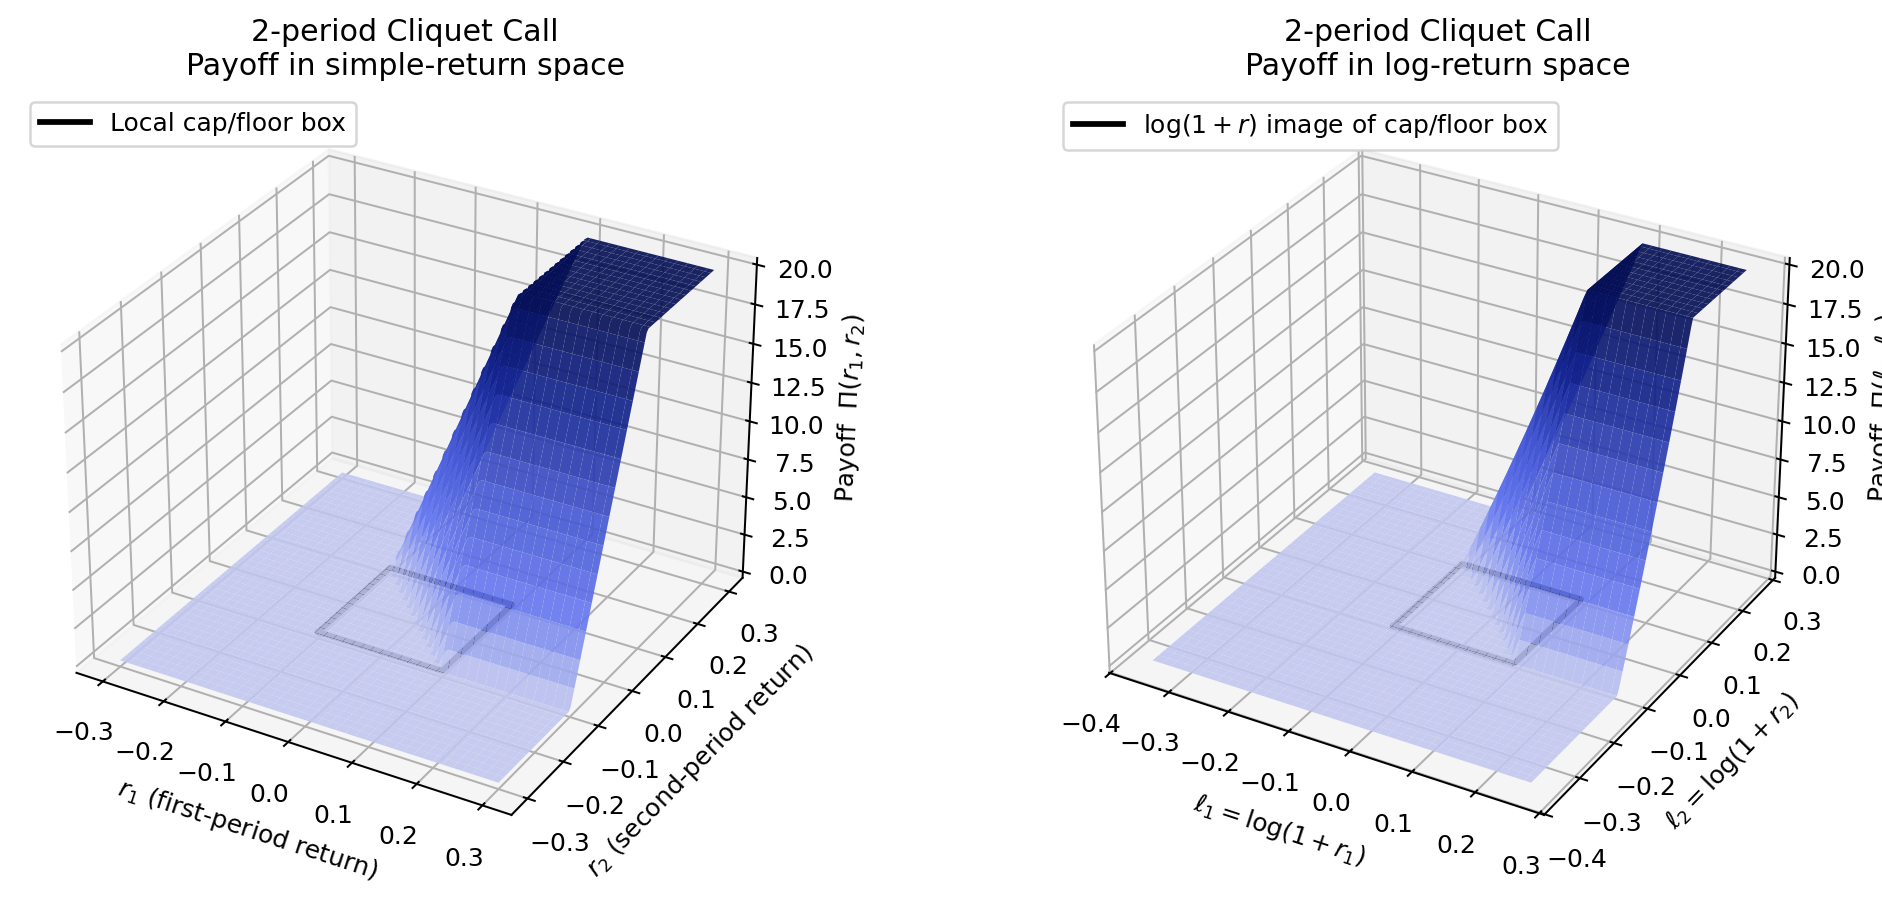

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list(
    "my_cmap",
    [
        "#c1c7efff",  # light
        "#6376efff",  # mid-light
        "#4154d1ff",  # mid
        "#112291ff",  # mid-dark
        "#020d53ff"   # dark
    ]
)

# =============================
# Parameters
# =============================
S0    = 100.0
K     = 100.0       # strike of the Cliquet-style call
floor = -0.10       # -10% floor on each local return
cap   =  0.10       # +10% cap on each local return

# Grid for *simple* (normal) returns r1, r2
r_min, r_max = -0.30, 0.30   # -30% .. +30% raw returns
n_points = 120

r1 = np.linspace(r_min, r_max, n_points)
r2 = np.linspace(r_min, r_max, n_points)
R1, R2 = np.meshgrid(r1, r2)

def cliquet_call_payoff_from_returns(R1, R2, S0, K, floor, cap):
    """
    Two-period Cliquet-style call:
      - clip each local return by [floor, cap]
      - effective final level: S_cliq = S0 * (1 + r1_clip + r2_clip)
      - payoff = max(S_cliq - K, 0)
    """
    R1_clip = np.clip(R1, floor, cap)
    R2_clip = np.clip(R2, floor, cap)
    total_local = 1.0 + R1_clip + R2_clip           # total growth factor
    S_cliq = S0 * total_local                       # effective final level
    payoff = np.maximum(S_cliq - K, 0.0)
    return payoff, S_cliq, R1_clip, R2_clip

payoff_normal, S_cliq_normal, R1c, R2c = cliquet_call_payoff_from_returns(
    R1, R2, S0, K, floor, cap
)

# =============================
# Log-return domain
# =============================
# Define grid in log-returns ℓ1, ℓ2
# ℓ = log(1 + r)  where r ∈ [r_min, r_max]
log_min = np.log(1.0 + r_min)
log_max = np.log(1.0 + r_max)

l1 = np.linspace(log_min, log_max, n_points)
l2 = np.linspace(log_min, log_max, n_points)
L1, L2 = np.meshgrid(l1, l2)

# Convert back to simple returns to reuse payoff function
R1_log = np.exp(L1) - 1.0
R2_log = np.exp(L2) - 1.0

payoff_log, S_cliq_log, R1c_log, R2c_log = cliquet_call_payoff_from_returns(
    R1_log, R2_log, S0, K, floor, cap
)

# =============================
# Plot 3D surfaces
# =============================
fig = plt.figure(figsize=(12, 5), dpi=180)

# ---------- 1) Simple-return domain ----------
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf1 = ax1.plot_surface(
    R1, R2, payoff_normal,
    cmap=my_cmap,
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax1.set_title("2-period Cliquet Call\nPayoff in simple-return space")
ax1.set_xlabel(r"$r_1$ (first-period return)")
ax1.set_ylabel(r"$r_2$ (second-period return)")
ax1.set_zlabel(r"Payoff  $\Pi(r_1,r_2)$")

# Draw the cap/floor rectangle in the (r1, r2) plane
ax1.plot(
    [floor, cap,  cap,  floor, floor],
    [floor, floor, cap, cap,   floor],
    [0,     0,     0,   0,     0],
    color="black",
    linewidth=2.3,
    label="Local cap/floor box"
)
ax1.legend(loc="upper left")

# ---------- 2) Log-return domain ----------
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
surf2 = ax2.plot_surface(
    L1, L2, payoff_log,
    cmap=my_cmap,
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax2.set_title("2-period Cliquet Call\nPayoff in log-return space")
ax2.set_xlabel(r"$\ell_1 = \log(1+r_1)$")
ax2.set_ylabel(r"$\ell_2 = \log(1+r_2)$")
ax2.set_zlabel(r"Payoff  $\Pi(\ell_1,\ell_2)$")

# Show the image of the cap/floor box under log(1 + r)
lfloor = np.log(1.0 + floor)
lcap   = np.log(1.0 + cap)
ax2.plot(
    [lfloor, lcap,  lcap,  lfloor, lfloor],
    [lfloor, lfloor, lcap, lcap,   lfloor],
    [0,      0,      0,    0,      0],
    color="black",
    linewidth=2.3,
    label=r"$\log(1 + r)$ image of cap/floor box"
)
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()
# --- Save as PNG ---
fig.savefig("figures/2_cliquet_option_payoff.png", dpi=300, bbox_inches="tight", transparent=False)

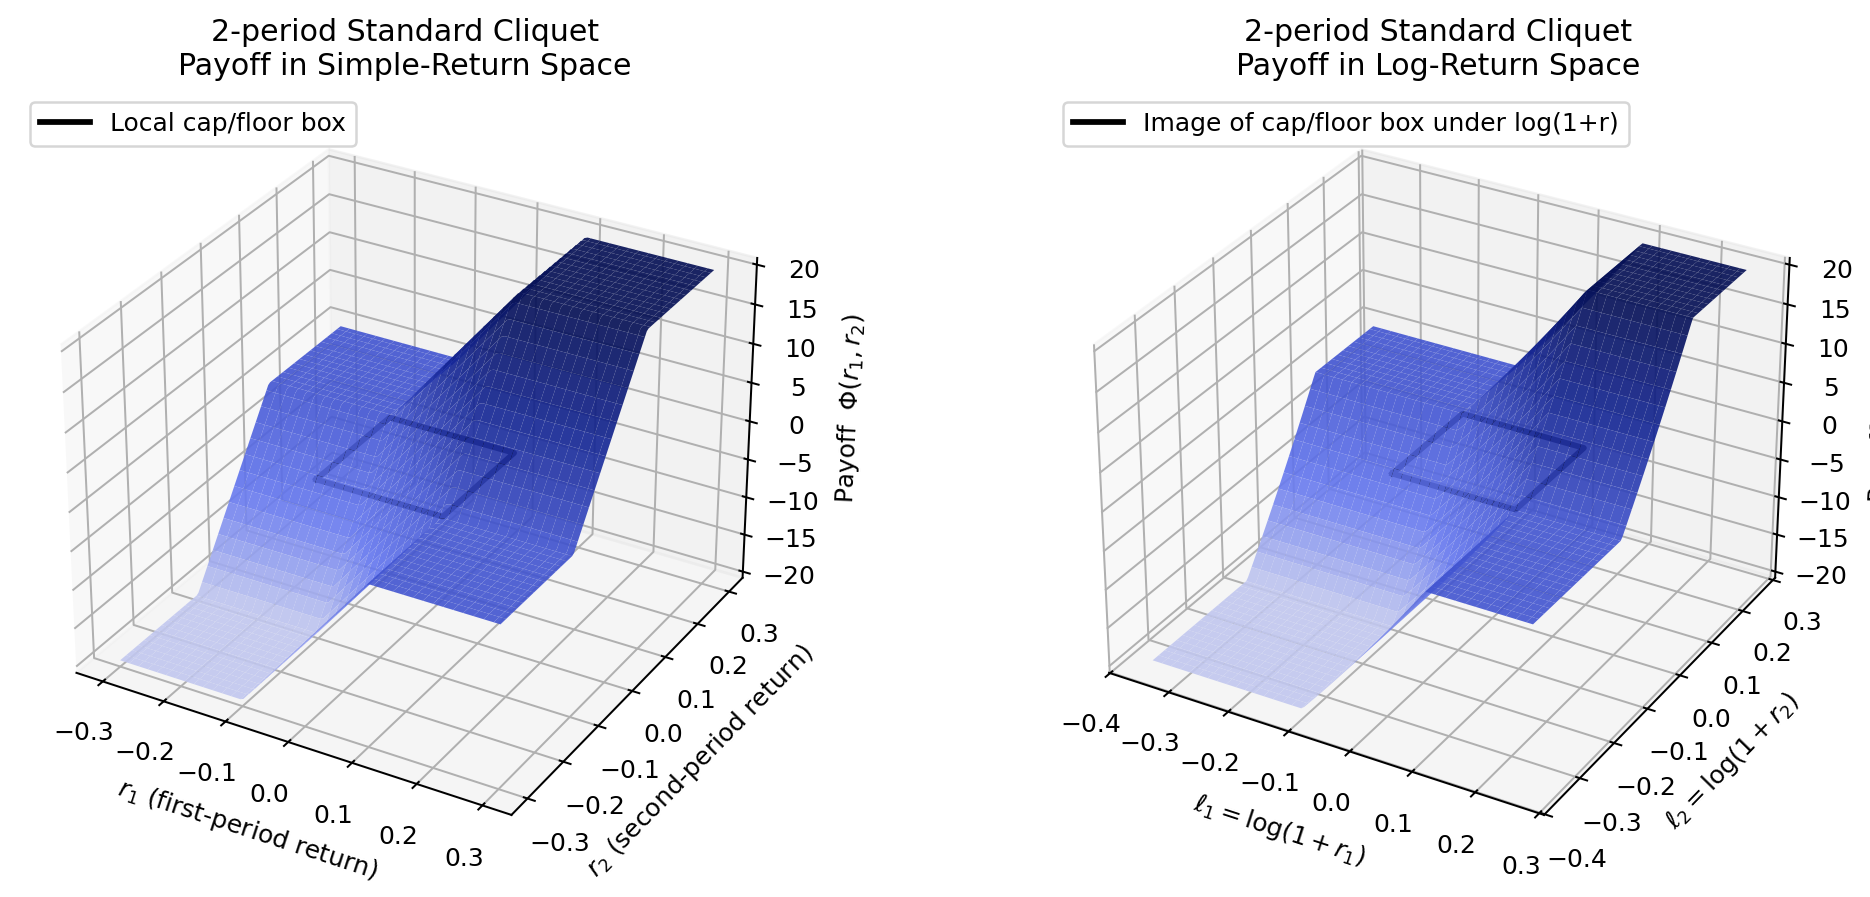

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap
my_cmap = LinearSegmentedColormap.from_list(
    "my_cmap",
    [
        "#c1c7efff",  # light
        "#6376efff",  # mid-light
        "#4154d1ff",  # mid
        "#112291ff",  # mid-dark
        "#020d53ff"   # dark
    ]
)

# =============================
# Parameters
# =============================
S0    = 100.0
floor = -0.10       # -10% floor on each local return
cap   =  0.10       # +10% cap on each local return

# Grid for simple (normal) returns r1, r2
r_min, r_max = -0.30, 0.30   # −30% … +30% raw returns
n_points = 120

r1 = np.linspace(r_min, r_max, n_points)
r2 = np.linspace(r_min, r_max, n_points)
R1, R2 = np.meshgrid(r1, r2)

def cliquet_standard_payoff_from_returns(R1, R2, S0, floor, cap):
    """
    Two-period *standard* (non-option) Cliquet payoff:

        - clip each local return by [floor, cap]
        - total clipped sum: S_clip = clip(r1) + clip(r2)
        - payoff = S0 * S_clip

    Note:
        Because floor < 0, the payoff can be negative if both clipped returns are negative.
    """
    R1_clip = np.clip(R1, floor, cap)
    R2_clip = np.clip(R2, floor, cap)
    total_clipped = R1_clip + R2_clip
    payoff = S0 * total_clipped
    return payoff, total_clipped, R1_clip, R2_clip

payoff_normal, total_clipped_normal, R1c, R2c = cliquet_standard_payoff_from_returns(
    R1, R2, S0, floor, cap
)

# =============================
# Log-return domain
# =============================
# ℓ = log(1 + r), with r ∈ [r_min, r_max]
log_min = np.log(1.0 + r_min)
log_max = np.log(1.0 + r_max)

l1 = np.linspace(log_min, log_max, n_points)
l2 = np.linspace(log_min, log_max, n_points)
L1, L2 = np.meshgrid(l1, l2)

# Convert back to simple returns so we can reuse the payoff function
R1_log = np.exp(L1) - 1.0
R2_log = np.exp(L2) - 1.0

payoff_log, total_clipped_log, R1c_log, R2c_log = cliquet_standard_payoff_from_returns(
    R1_log, R2_log, S0, floor, cap
)

# =============================
# Plot 3D surfaces
# =============================
fig = plt.figure(figsize=(12, 5), dpi=180)

# ---------- 1) Simple-return domain ----------
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf1 = ax1.plot_surface(
    R1, R2, payoff_normal,
    cmap=my_cmap,
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax1.set_title("2-period Standard Cliquet\nPayoff in Simple-Return Space")
ax1.set_xlabel(r"$r_1$ (first-period return)")
ax1.set_ylabel(r"$r_2$ (second-period return)")
ax1.set_zlabel(r"Payoff  $\Phi(r_1,r_2)$")

# Draw the cap/floor region in the (r1, r2) plane
ax1.plot(
    [floor, cap,  cap,  floor, floor],
    [floor, floor, cap, cap,   floor],
    [0,     0,     0,   0,     0],
    color="black",
    linewidth=2.3,
    label="Local cap/floor box"
)
ax1.legend(loc="upper left")

# ---------- 2) Log-return domain ----------
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
surf2 = ax2.plot_surface(
    L1, L2, payoff_log,
    cmap=my_cmap,
    linewidth=0,
    antialiased=True,
    alpha=0.9
)

ax2.set_title("2-period Standard Cliquet\nPayoff in Log-Return Space")
ax2.set_xlabel(r"$\ell_1 = \log(1+r_1)$")
ax2.set_ylabel(r"$\ell_2 = \log(1+r_2)$")
ax2.set_zlabel(r"Payoff  $\Phi(\ell_1,\ell_2)$")

# Image of the cap/floor box under log(1+r)
lfloor = np.log(1.0 + floor)
lcap   = np.log(1.0 + cap)
ax2.plot(
    [lfloor, lcap,  lcap,  lfloor, lfloor],
    [lfloor, lfloor, lcap, lcap,   lfloor],
    [0,      0,      0,    0,      0],
    color="black",
    linewidth=2.3,
    label="Image of cap/floor box under log(1+r)"
)
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()
# --- Save as PNG ---
fig.savefig("figures/2_cliquet_payoff.png", dpi=300, bbox_inches="tight", transparent=False)

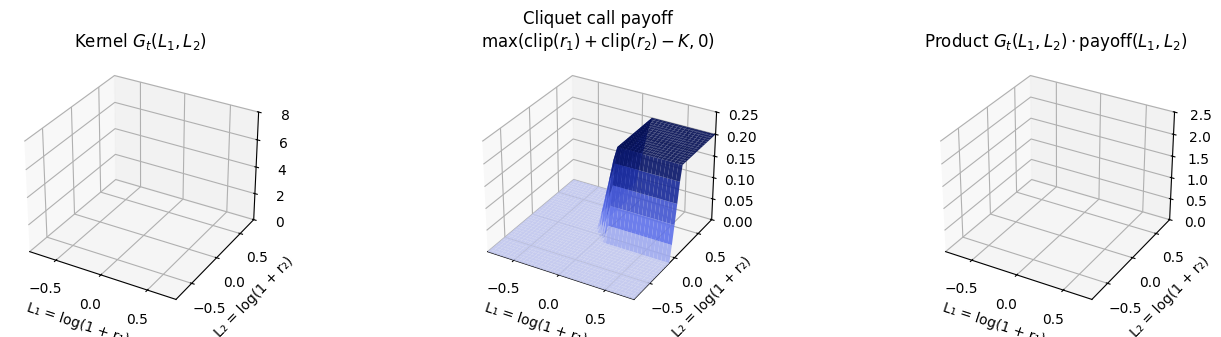

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list(
    "my_cmap",
    [
        "#c1c7efff",  # light
        "#6376efff",  # mid-light
        "#4154d1ff",  # mid
        "#112291ff",  # mid-dark
        "#020d53ff"   # dark
    ]
)

# ============================================================
#  Basic parameters for a 2-period Cliquet call on returns
# ============================================================
S0 = 100.0
K_cliquet = 0.0           # strike on the sum of clipped returns
floor = -0.10             # -10% local floor
cap   =  0.10             # +10% local cap

# ---- Domain in L = log(1 + r) ----
L_min, L_max = -0.8, 0.8  # domain for log(1 + r)
n_grid = 38
L1 = np.linspace(L_min, L_max, n_grid)
L2 = np.linspace(L_min, L_max, n_grid)
L1_grid, L2_grid = np.meshgrid(L1, L2)

# Grid step (used to approximate the integral over L-space)
dL = L1[1] - L1[0]

# Convert to simple returns only for payoff and clipping
R1 = np.expm1(L1_grid)   # = exp(L1) - 1
R2 = np.expm1(L2_grid)   # = exp(L2) - 1

# ============================================================
#  Payoff: call on a 2-period Cliquet in terms of r1, r2
# ============================================================
def cliquet_call_payoff(r1, r2, floor, cap, K_cliquet):
    """
    2-period Cliquet-style call:

      1) Clip each local return r_i inside [floor, cap].
      2) Sum the clipped returns: total = clip(r1) + clip(r2).
      3) Payoff = max(total − K_cliquet, 0).
    """
    c1 = np.clip(r1, floor, cap)
    c2 = np.clip(r2, floor, cap)
    total = c1 + c2
    return np.maximum(total - K_cliquet, 0.0)

P = cliquet_call_payoff(R1, R2, floor, cap, K_cliquet)

# ============================================================
#  2D Gaussian kernel in L = log(1 + r)
# ============================================================
var_max = 0.35**2
var_min = 0.02**2

def gaussian_kernel_two_periods(L1, L2, t_total, var_min, var_max):
    """
    Two-period 2D Gaussian kernel in (L1, L2), with time-staggered
    “concentration” of each dimension:

      t_total in [0, 1]:
          - var1 decreases from var_max to var_min  (1st period fixing)
          - var2 stays at var_max                   (2nd period still “far”)

      t_total in [1, 2]:
          - var1 is fixed at var_min                (1st period essentially fixed)
          - var2 decreases from var_max to var_min  (2nd period fixing)
    """
    if t_total <= 1.0:
        tau1 = 1.0 - t_total
        var1 = var_min + (var_max - var_min) * tau1
        var2 = var_max
    else:
        var1 = var_min
        tau2 = 2.0 - t_total
        var2 = var_min + (var_max - var_min) * tau2

    coef = 1.0 / (2.0 * np.pi * np.sqrt(var1 * var2))
    expo = - (L1**2 / (2.0 * var1) + L2**2 / (2.0 * var2))
    return coef * np.exp(expo)

# ============================================================
#  3D figure: kernel, payoff, and product K × payoff
# ============================================================
fig = plt.figure(figsize=(14, 4))
axK = fig.add_subplot(1, 3, 1, projection='3d')
axP = fig.add_subplot(1, 3, 2, projection='3d')
axC = fig.add_subplot(1, 3, 3, projection='3d')

# Z-limits for each panel (purely cosmetic)
zK_max = 8.0
zP_max = 0.25
zC_max = 2.5

for ax in (axK, axP, axC):
    ax.set_xlim(L_min, L_max)
    ax.set_ylim(L_min, L_max)
    ax.set_xlabel("L₁ = log(1 + r₁)")
    ax.set_ylabel("L₂ = log(1 + r₂)")

axK.set_zlim(0.0, zK_max)
axP.set_zlim(0.0, zP_max)
axC.set_zlim(0.0, zC_max)

axK.set_title("Kernel $G_t(L_1, L_2)$")
axP.set_title(
    "Cliquet call payoff\n"
    "$\\max(\\mathrm{clip}(r_1)+\\mathrm{clip}(r_2)-K, 0)$"
)
axC.set_title(
    "Product $G_t(L_1, L_2)\\cdot \\text{payoff}(L_1, L_2)$"
)

# Fixed payoff surface (does not change with time)
surfP = axP.plot_surface(
    L1_grid, L2_grid, P,
    cmap=my_cmap, edgecolor="none", alpha=0.9
)

# ======== Texts outside the axes, on the figure ========
# Global time / state text
time_text = fig.text(
    0.38, 0.98,
    "",
    ha="left",
    va="top",
    fontsize=9,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.8
    )
)

# Phase description (which period is currently diffusing)
phase_text = fig.text(
    0.02, 0.98,
    "",
    ha="left",
    va="top",
    fontsize=9,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.8
    )
)

# Dynamic text summarizing “price ≈ area under K × payoff”
price_text = fig.text(
    0.78, 0.98,
    "",
    ha="left",
    va="top",
    fontsize=9,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.8
    )
)

surfK = None
surfC = None

# ============================================================
#  Frames with pauses: t_total ∈ [0, 2]
# ============================================================
n_core_frames = 120
base_indices = np.arange(n_core_frames)

def index_to_t(idx):
    """Map a core frame index to the global time t_total ∈ [0, 2]."""
    return 2.0 * idx / (n_core_frames - 1)

idx_mid = np.argmin(np.abs(index_to_t(base_indices) - 1.0))
idx_end = n_core_frames - 1

pause_len = 20  # number of extra frames to hold at key times
frames = []
for i in base_indices:
    frames.append(i)
    if i == 0:
        frames.extend([i] * (pause_len - 1))
    if i == idx_mid:
        frames.extend([i] * (pause_len - 1))
    if i == idx_end:
        frames.extend([i] * (pause_len - 1))

# ============================================================
#  init and update for the animation
# ============================================================
def init():
    """
    Initialize surfaces at t = 0 and set the initial explanatory text.
    """
    global surfK, surfC

    t_total = 0.0
    K = gaussian_kernel_two_periods(L1_grid, L2_grid, t_total, var_min, var_max)
    C = K * P

    surfK = axK.plot_surface(
        L1_grid, L2_grid, K,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )
    surfC = axC.plot_surface(
        L1_grid, L2_grid, C,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )

    time_text.set_text("t = 0.00")
    phase_text.set_text(
        "Start:\n"
        "Kernel is wide in L₁ and L₂.\n"
        "Both periods are far from fixing."
    )

    # Initial “price” just for context
    approx_price = np.sum(C) * (dL * dL)
    price_text.set_text(
        f"$\\exp(-rt)$ · ∬ K · payoff dL₁ dL₂ ≈ {approx_price:.4f}\n"
        "(visual approximation on a finite grid)"
    )

    return surfK, surfP, surfC, time_text, phase_text, price_text

def update(frame_index):
    """
    Update kernel, product, and explanatory text for frame `frame_index`.
    """
    global surfK, surfC

    i_base = frames[frame_index]
    t_total = index_to_t(i_base)

    # Remove the old surfaces before plotting new ones
    if surfK is not None:
        surfK.remove()
    if surfC is not None:
        surfC.remove()

    # Recompute kernel and product at this time
    K = gaussian_kernel_two_periods(L1_grid, L2_grid, t_total, var_min, var_max)
    C = K * P

    surfK = axK.plot_surface(
        L1_grid, L2_grid, K,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )
    surfC = axC.plot_surface(
        L1_grid, L2_grid, C,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )

    # Approximate convolution integral as a Riemann sum
    approx_price = np.sum(C) * (dL * dL)

    epsilon = 1e-3

    # Time label
    time_text.set_text(
        f"t ≈ {t_total:.2f}\n"
        f"(0–1: 1st period, 1–2: 2nd period)"
    )

    # Phase description depending on t_total
    if t_total < 0.05:
        desc = (
            "Start:\n"
            "Kernel is wide in both L₁ and L₂.\n"
            "Both periods are far from fixing."
        )
    elif t_total < 0.95:
        desc = (
            "Phase 1:\n"
            "Variance in L₁ is shrinking (1st period near fixing).\n"
            "Kernel in L₂ remains wide (2nd period not yet fixed)."
        )
    elif t_total < 1.05:
        desc = (
            "Around t ≈ 1:\n"
            "First period is almost fixed (kernel very narrow in L₁).\n"
            "Second period is still widely spread in L₂."
        )
    elif t_total < 1.95:
        desc = (
            "Phase 2:\n"
            "L₁ is essentially fixed (minimal variance).\n"
            "Now the kernel concentrates in L₂ "
            "(2nd period approaching fixing)."
        )
    else:
        desc = (
            "Final t ≈ 2:\n"
            "Both periods are almost fixed.\n"
            "Kernel is highly concentrated at a single point in (L₁, L₂)."
        )
    phase_text.set_text(desc)

    # Price text: convolution vs final payoff interpretation
    if abs(t_total - 2.0) < epsilon:
        # At maturity we interpret the value as the payoff at the most likely state.
        # Option 1 (simpler) would be r1 = r2 = 0; instead we:
        # use the grid point where K is maximal.
        max_idx = np.unravel_index(np.argmax(K), K.shape)
        r1_final = R1[max_idx]
        r2_final = R2[max_idx]

        true_payoff = cliquet_call_payoff(
            r1_final, r2_final, floor, cap, K_cliquet
        )
        approx_price = true_payoff  # override convolution with actual payoff

        price_text.set_text(
            "Maturity (t = 2):\n"
            f"Option value = payoff at that state ≈ {approx_price:.4f}"
        )
    else:
        price_text.set_text(
            f"$\\exp(-r t)$ · ∬ K_t · payoff dL₁ dL₂ ≈ {approx_price:.4f}\n"
        )

    return surfK, surfP, surfC, time_text, phase_text, price_text

# ============================================================
#  Build animation
# ============================================================
anim = FuncAnimation(
    fig,
    update,
    frames=len(frames),
    init_func=init,
    interval=80,
    blit=False
)

plt.tight_layout(rect=[0, 0.06, 1, 0.90])
plt.show()

from matplotlib.animation import PillowWriter
anim.save(
    "figures/2_cliquet_2d_call_log_domain.gif",
    writer=PillowWriter(fps=10), dpi = 300
)

<>:120: SyntaxWarning: invalid escape sequence '\c'
<>:120: SyntaxWarning: invalid escape sequence '\c'
/var/folders/jg/qxxd4l517rj259v_s_gwlg980000gn/T/ipykernel_73168/2865418095.py:120: SyntaxWarning: invalid escape sequence '\c'
  axC.set_title("Product $G_t(L_1, L_2)\cdot \text{payoff}(L_1, L_2)$")


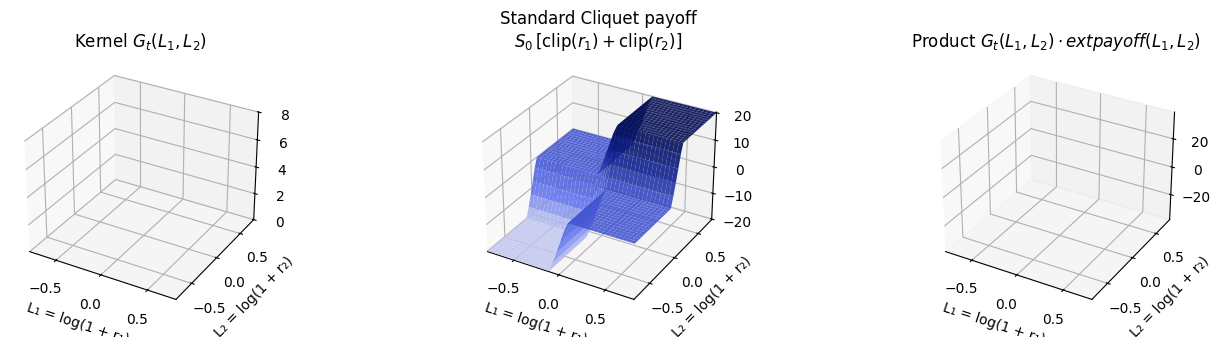

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list(
    "my_cmap",
    [
        "#c1c7efff",  # light
        "#6376efff",  # mid-light
        "#4154d1ff",  # mid
        "#112291ff",  # mid-dark
        "#020d53ff"   # dark
    ]
)

# ============================================================
#  Basic parameters for a 2-period *standard* Cliquet
# ============================================================
S0 = 100.0
K_cliquet = 0.0           # strike on the sum of clipped returns (unused here)
floor = -0.10             # -10% local floor
cap   =  0.10             # +10% local cap

# ---- Domain in L = log(1 + r) ----
L_min, L_max = -0.8, 0.8  # domain in log(1 + r)
n_grid = 38
L1 = np.linspace(L_min, L_max, n_grid)
L2 = np.linspace(L_min, L_max, n_grid)
L1_grid, L2_grid = np.meshgrid(L1, L2)

# Grid step (used to approximate the integral ∬·dL₁ dL₂)
dL = L1[1] - L1[0]

# Convert to simple returns ONLY for payoff and clipping
R1 = np.expm1(L1_grid)   # = exp(L1) - 1
R2 = np.expm1(L2_grid)   # = exp(L2) - 1

# ============================================================
#  Payoff: standard 2-period Cliquet in terms of returns r1, r2
# ============================================================
def cliquet_standard_payoff(r1, r2, floor, cap, S0):
    """
    Standard (non-option) 2-period Cliquet payoff:

        1) Clip each local return in [floor, cap]:
               c_i = clip(r_i; floor, cap)
        2) Sum the clipped returns:
               total_clipped = c1 + c2
        3) Payoff = S0 * total_clipped
           (this can be negative if both clipped returns are negative).
    """
    c1 = np.clip(r1, floor, cap)
    c2 = np.clip(r2, floor, cap)
    total_clipped = c1 + c2      # sum of clipped local returns
    return S0 * total_clipped    # standard Cliquet payoff

P = cliquet_standard_payoff(R1, R2, floor, cap, S0)

# ============================================================
#  2D Gaussian kernel in L = log(1 + r)
# ============================================================
var_max = 0.35**2
var_min = 0.02**2

def gaussian_kernel_two_periods(L1, L2, t_total, var_min, var_max):
    """
    Two-period 2D Gaussian kernel with different variances:

      For t_total in [0, 1]:
          - var1 decreases from var_max to var_min  (1st period concentrates)
          - var2 stays at var_max                  (2nd period still diffuse)

      For t_total in [1, 2]:
          - var1 is frozen at var_min              (1st period essentially fixed)
          - var2 decreases from var_max to var_min (2nd period concentrates)
    """
    if t_total <= 1.0:
        tau1 = 1.0 - t_total
        var1 = var_min + (var_max - var_min) * tau1
        var2 = var_max
    else:
        var1 = var_min
        tau2 = 2.0 - t_total
        var2 = var_min + (var_max - var_min) * tau2

    coef = 1.0 / (2.0 * np.pi * np.sqrt(var1 * var2))
    expo = - (L1**2 / (2.0 * var1) + L2**2 / (2.0 * var2))
    return coef * np.exp(expo)

# ============================================================
#  3D Figure (Kernel, Payoff, Product)
# ============================================================
fig = plt.figure(figsize=(14, 4))
axK = fig.add_subplot(1, 3, 1, projection='3d')
axP = fig.add_subplot(1, 3, 2, projection='3d')
axC = fig.add_subplot(1, 3, 3, projection='3d')

# z-limits
zK_max = 8.0
zP_max = 20.25
zC_max = 38.5

for ax in (axK, axP, axC):
    ax.set_xlim(L_min, L_max)
    ax.set_ylim(L_min, L_max)
    ax.set_xlabel("L₁ = log(1 + r₁)")
    ax.set_ylabel("L₂ = log(1 + r₂)")

axK.set_zlim(0.0, zK_max)
axP.set_zlim(-zP_max, zP_max)
axC.set_zlim(-zC_max, zC_max)

axK.set_title("Kernel $G_t(L_1, L_2)$")
axP.set_title(
    "Standard Cliquet payoff\n"
    r"$S_0\,[\mathrm{clip}(r_1)+\mathrm{clip}(r_2)]$"
)
axC.set_title("Product $G_t(L_1, L_2)\cdot \text{payoff}(L_1, L_2)$")

# Fixed payoff surface (does not change with time)
surfP = axP.plot_surface(
    L1_grid, L2_grid, P,
    cmap=my_cmap, edgecolor="none", alpha=0.9
)

# ======== Texts outside the axes, on the figure ========
# Global time / state
time_text = fig.text(
    0.38, 0.98,
    "",
    ha="left",
    va="top",
    fontsize=9,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.8
    )
)

# Phase description (which period is currently diffusing)
phase_text = fig.text(
    0.02, 0.98,
    "",
    ha="left",
    va="top",
    fontsize=9,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.8
    )
)

# Dynamic text: “price ≈ area under K × payoff”
price_text = fig.text(
    0.78, 0.98,
    "",
    ha="left",
    va="top",
    fontsize=9,
    color="blue",
    bbox=dict(
        facecolor="white",
        edgecolor="blue",
        boxstyle="round,pad=0.3",
        alpha=0.8
    )
)

surfK = None
surfC = None

# ============================================================
#  Frames with pauses: t_total ∈ [0, 2]
# ============================================================
n_core_frames = 120
base_indices = np.arange(n_core_frames)

def index_to_t(idx):
    """Map a core frame index to the global time t_total ∈ [0, 2]."""
    return 2.0 * idx / (n_core_frames - 1)

idx_mid = np.argmin(np.abs(index_to_t(base_indices) - 1.0))
idx_end = n_core_frames - 1

pause_len = 20  # how many frames to “hold” at key times
frames = []
for i in base_indices:
    frames.append(i)
    if i == 0:
        frames.extend([i] * (pause_len - 1))
    if i == idx_mid:
        frames.extend([i] * (pause_len - 1))
    if i == idx_end:
        frames.extend([i] * (pause_len - 1))

# ============================================================
#  init and update for the animation
# ============================================================
def init():
    """
    Initialize surfaces at t = 0 and set the initial descriptive text.
    """
    global surfK, surfC

    t_total = 0.0
    K = gaussian_kernel_two_periods(L1_grid, L2_grid, t_total, var_min, var_max)
    C = K * P

    surfK = axK.plot_surface(
        L1_grid, L2_grid, K,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )
    surfC = axC.plot_surface(
        L1_grid, L2_grid, C,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )

    time_text.set_text("t = 0.00")
    phase_text.set_text(
        "Start:\n"
        "Kernel is wide in L₁ and L₂.\n"
        "Both periods are far from fixing."
    )

    # Initial area (just to have some meaningful text)
    approx_price = np.sum(C) * (dL * dL)
    price_text.set_text(
        f"$\\exp(-rt)$·∬ K·payoff dL₁ dL₂ ≈ {approx_price:.4f}\n"
        "(visual approximation on a finite grid)"
    )

    return surfK, surfP, surfC, time_text, phase_text, price_text

def update(frame_index):
    """
    Update the kernel, product, and descriptive texts for frame_index.
    """
    global surfK, surfC

    i_base = frames[frame_index]
    t_total = index_to_t(i_base)

    # Remove old surfaces
    if surfK is not None:
        surfK.remove()
    if surfC is not None:
        surfC.remove()

    # New kernel and product
    K = gaussian_kernel_two_periods(L1_grid, L2_grid, t_total, var_min, var_max)
    C = K * P

    surfK = axK.plot_surface(
        L1_grid, L2_grid, K,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )
    surfC = axC.plot_surface(
        L1_grid, L2_grid, C,
        cmap=my_cmap, edgecolor="none", alpha=0.9
    )

    # ---- Approximate integral = “visual price” ----
    approx_price = np.sum(C) * (dL * dL)

    epsilon = 1e-3

    # Time label
    time_text.set_text(
        f"t ≈ {t_total:.2f} \n"
        f"(0–1: 1st period, 1–2: 2nd period)"
    )

    # Phase description
    if t_total < 0.05:
        desc = (
            "Start:\n"
            "Kernel is wide in both L₁ and L₂.\n"
            "Both periods are far from fixing."
        )
    elif t_total < 0.95:
        desc = (
            "Phase 1:\n"
            "Variance in L₁ is shrinking (1st period approaches fixing).\n"
            "Kernel in L₂ is still wide (2nd period not yet fixed)."
        )
    elif t_total < 1.05:
        desc = (
            "Around t ≈ 1:\n"
            "First period is almost fixed (kernel very narrow in L₁).\n"
            "Second period is still widely spread in L₂."
        )
    elif t_total < 1.95:
        desc = (
            "Phase 2:\n"
            "L₁ is essentially fixed (minimal variance).\n"
            "Now the kernel concentrates in L₂ "
            "(2nd period approaches fixing)."
        )
    else:
        desc = (
            "Final t ≈ 2:\n"
            "Both periods are almost fixed.\n"
            "Kernel is highly concentrated at a single point in (L₁, L₂)."
        )
    phase_text.set_text(desc)

    # ---- Price text: convolution vs “final state” interpretation ----
    if abs(t_total - 2.0) < epsilon:
        # At maturity: interpret value as payoff at the most likely state.
        # (Alternative simpler option would be r1 = r2 = 0.)
        max_idx = np.unravel_index(np.argmax(K), K.shape)
        r1_final = R1[max_idx]
        r2_final = R2[max_idx]

        # Reuse the Cliquet *call on returns* payoff to keep the comparison
        true_payoff = cliquet_standard_payoff(
            r1_final, r2_final, floor, cap, S0
        )
        approx_price = true_payoff  # override convolution with payoff at that point

        price_text.set_text(
            "Maturity (t = 2):\n"
            f"Standard Cliquet value at that state ≈ {approx_price:.4f}"
        )
    else:
        price_text.set_text(
            f"$\\exp(-r t)$·∬ K_t · payoff dL₁ dL₂ ≈ {approx_price:.4f}\n"
        )

    return surfK, surfP, surfC, time_text, phase_text, price_text

# ============================================================
#  Build and save the animation
# ============================================================
anim = FuncAnimation(
    fig,
    update,
    frames=len(frames),
    init_func=init,
    interval=80,
    blit=False
)

plt.tight_layout(rect=[0, 0.06, 1, 0.90])
plt.show()

from matplotlib.animation import PillowWriter
anim.save(
    "figures/2_cliquet_2d_standard.gif",
    writer=PillowWriter(fps=10), dpi = 300
)

____
Code snippets
____

____
Formulas
____

In [22]:
import os
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Configure where to save and how to name files
# ---------------------------------------------------
output_dir = "formulas"         
file_prefix = "2_formula_"      

os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------------------
# 2. LaTeX formulas here
# ---------------------------------------------------
formulas = [
    r"V(T_{\text{outer}}) = \max( C(T_{\text{outer}}, S_T)-K_2,\, 0 )",
    r"C(t,S) = \text{Black–Scholes}(S, t; K_1, \sigma, r)",
    r"C_t + \frac{1}{2} \sigma^2 S^2 C_{SS} + r S C_S-rC = 0, \qquad C(T_{\text{inner}},S) = \max(S-K_1,0)",
    r"V_t + \frac{1}{2} \sigma^2 S^2 V_{SS} + r S V_S-rV = 0",

    r"V(t, S) >= \text{payoff}(S)",
    r"V(t_1, S) = \max( C(t_1, S),\, (S-K)_+)",
    r"V_t + \frac{1}{2} \sigma² S² V_{SS} + r S V_S -r V = 0, \qquad t \in (t_k, t_{k+1}),\ S>0",
    r"V(T,S) = \Phi(S)",
    r"V(t_k, S) = \max( \Phi(S),\; V_{\text{cont}}(t_k^+, S))",
    
    r"\max( V_t + \frac{1}{2} \sigma² S² V_{SS} + r S V_S -r V = 0,\; \Phi(S)-V ) = 0, \qquad 0 < t < T, S>0 , \qquad V(T,S)=\Phi(S)",
    
]

# ---------------------------------------------------
# 3. Loop over formulas and save each as PNG
# ---------------------------------------------------
for i, formula in enumerate(formulas, start=1):
    fig, ax = plt.subplots(figsize=(6, 0.1))  # adjust size as you like

    ax.axis("off")

    # Wrap the formula with $...$ so matplotlib treats it as math
    ax.text(
        0.5, 0.5,
        f"${formula}$",
        ha="center",
        va="center",
        fontsize=24,
    )

    filename = f"{file_prefix}{i}.png"
    filepath = os.path.join(output_dir, filename)

    fig.savefig(
        filepath,
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.2,
        transparent=True,   # nice for Medium on white/colored backgrounds
    )
    plt.close(fig)

    print(f"Saved: {filepath}")

Saved: formulas/2_formula_1.png
Saved: formulas/2_formula_2.png
Saved: formulas/2_formula_3.png
Saved: formulas/2_formula_4.png
Saved: formulas/2_formula_5.png
Saved: formulas/2_formula_6.png
Saved: formulas/2_formula_7.png
Saved: formulas/2_formula_8.png
Saved: formulas/2_formula_9.png
Saved: formulas/2_formula_10.png


<h3>2. How each of these exotic families modifies the geometry of the pricing problem</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>3. Why these geometric changes break the assumptions that make the Black–Scholes formula easily solvable, and why closed-form solutions exist only in special cases</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>4. How finite-difference schemes (explicit, implicit, Crank–Nicolson) generalize the heat-equation intuition to handle early exercise, barriers, and other structural constraints</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>5. How projection and constraint-solving methods (PSOR, projected Newton, semi-smooth Newton) enforce the exercise condition in American-style problems</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>6. How Poisson subordination ideas extend the heat-equation intuition</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>7. How Monte-Carlo methods tackle high-dimensional and path-dependent exotics, including regression for early-exercise and stochastic mesh techniques</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>8. Why quasi–Monte-Carlo (low-discrepancy) sequences often outperform standard simulation by injecting structure into the sampling of uncertainty</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>9. How the choice of numerical method shapes accuracy, stability, and computational cost, and how practitioners balance these trade-offs when implementing real pricing engines</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

<h3>10. A practical map matching each numerical method to each exotic option type</h3>

____
Graphs or animations
____

____
Code snippets
____

____
Formulas
____

In [ ]:
# I had persistent issues rendering matrices directly with Matplotlib's mathtext
# and usetex, so here I switched to calling LaTeX + dvipng explicitly.
# This is more robust and works for any formula (including big matrices).

import os
import subprocess

output_dir = "formulas"
file_prefix = "8_formula_"
os.makedirs(output_dir, exist_ok=True)

formulas = [
    r"""
    T =
    \begin{pmatrix}
    -2 & 1 & 0 & \cdots & 0 \\
    1 & -2 & 1 & \cdots & 0 \\
    0 & 1 & -2 & \ddots & 0 \\
    \vdots & \vdots & \ddots & \ddots & 1 \\
    0 & 0 & 0 & 1 & -2
    \end{pmatrix}
    """,
    r"\mathbf{b} = -(u_0,\ 0,\ \ldots,\ 0,\ u_N)^\top"
]


def render_formula_to_png(formula, png_path, tex_name):
    tex_lines = [
        r"\documentclass[border=2pt]{standalone}",
        r"\usepackage{amsmath}",
        r"\begin{document}",
        f"${formula}$",
        r"\end{document}",
    ]
    tex_source = "\n".join(tex_lines)

    tex_file = tex_name + ".tex"

    # Write TeX
    with open(tex_file, "w") as f:
        f.write(tex_source)

    # Compile LaTeX → PDF
    subprocess.run(
        ["pdflatex", "-interaction=nonstopmode", tex_file],
        text=True,
        capture_output=True,
        check=True
    )

    pdf_file = tex_name + ".pdf"

    # Convert PDF → hi-res PNG
    subprocess.run(
        [
            "magick", "-density", "600",
            pdf_file,
            "-quality", "100",
            "-trim",
            png_path
        ],
        text=True,
        capture_output=True,
        check=True
    )

    # Cleanup auxiliary files
    for ext in (".aux", ".log", ".pdf", ".tex"):
        fname = tex_name + ext
        if os.path.exists(fname):
            os.remove(fname)


for i, formula in enumerate(formulas, start=11):
    tex_name = f"tmp_formula_{i}"
    filepath = os.path.join(output_dir, f"{file_prefix}{i}.png")
    render_formula_to_png(formula, filepath, tex_name)
    print("Saved:", filepath)